## TRANSFORMER: FIRST DRAFT

### IMPORTS

In [1]:
import sys
import os
from pathlib import Path

current_path = Path(os.getcwd())

project_root = current_path.parent.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Working in: {current_path}")
print(f"Root of the project: {project_root}")

try:
    import nuimages 
    import nuscenes
except ImportError as e:
    print(f"Error: {e}")

Working in: /root/nuscenes-devkit/python-sdk/main/notebooks
Root of the project: /root/nuscenes-devkit/python-sdk


In [2]:
import argparse
import pickle
from nuscenes import NuScenes
import os
import json
from nuscenes.map_expansion.map_api import NuScenesMap

from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
import torch
import numpy as np
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle
from nuscenes.eval.prediction.data_classes import Prediction

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.metrics import MinADEK, MinFDEK, RowMean
from nuscenes.prediction.models.backbone import ResNetBackbone

from matplotlib import pyplot as plt

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle

from nuscenes.map_expansion import arcline_path_utils
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet

from torch.utils.data import Dataset, DataLoader
from nuscenes.prediction.models.mtp import MTPLoss

import torch.nn as nn

MINI wayformer a partir d'embeddings

Primer s'ha hagut de fer els embeddings i concatenarlos. 

In [3]:
# shapes de entrada al Transformer (que prepararás después)
# bev_emb:      (batch_size, 1, D)
# agent_embs:   (batch_size, N_agents, D)
# lane_embs:    (batch_size, N_lanes, D)

# y luego los concatenas:
# tokens = torch.cat([bev_emb, agent_embs, lane_embs], dim=1)  # (B, T, D)


### agent embedding:

CADA AGENT TÉ AIXÒ: posición (x, y), velocidad, aceleración, heading (ángulo), tamaño (width, length),clase (car, pedestrian, bicycle…), historia pasada (opcional), estado actual (si está quieto o no, etc.)

amb una dimensionalidad podriem tenir un feature vector així: [x, y, vx, vy, ax, ay, heading_sin, heading_cos, width, length]


In [4]:
# def extract_agent_features(helper, instance_token, sample_token):
#     ann = helper.get_sample_annotation(instance_token, sample_token)

#     # Position
#     x, y, _ = ann["translation"]

#     # Velocity
#     vx, vy = helper.get_velocity_for_agent(instance_token, sample_token)

#     # Acceleration
#     ax, ay = helper.get_acceleration_for_agent(instance_token, sample_token)

#     # Heading (convert quaternion → sin/cos)
#     quat = ann["rotation"]  # [qw, qx, qy, qz]
#     yaw = Quaternion(quat).yaw_pitch_roll[0]
#     sin_yaw = np.sin(yaw)
#     cos_yaw = np.cos(yaw)

#     # Size
#     width, length, _ = ann["size"]

#     # Feature vector
#     features = np.array([x, y, vx, vy, ax, ay, sin_yaw, cos_yaw, width, length], dtype=np.float32)

#     return features  # shape (10,)


# ## PASSAR TOTS ELS AGENTS PER UN MLP PER TENIR AGENT EMBEDDING DE agent embedding (B, N_agents, D)
# class AgentEncoder(nn.Module):
#     def __init__(self, in_dim=10, hidden_dim=128, out_dim=128):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(in_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, out_dim)
#         )

#     def forward(self, agent_features):
#         """
#         agent_features: (B, N_agents, 10)
#         returns: (B, N_agents, out_dim)
#         """
#         return self.mlp(agent_features)

# MAX_AGENTS = 12  # como Waymo, puedes escoger 12–16

# def build_agent_embeddings(helper, sample_token, agent_encoder, device):
#     anns = helper.get_annotations_for_sample(sample_token)

#     features = []

#     for ann in anns:
#         instance_token = ann["instance_token"]
#         f = extract_agent_features(helper, instance_token, sample_token)
#         features.append(f)

#         if len(features) == MAX_AGENTS:
#             break

#     # Padding
#     while len(features) < MAX_AGENTS:
#         features.append(np.zeros(10, dtype=np.float32))

#     features = torch.tensor(features, device=device)  # (MAX_AGENTS, 10)
#     features = features.unsqueeze(0)  # (1, MAX_AGENTS, 10)

#     # Agent Encoder
#     with torch.no_grad():  # or leave gradients if end-to-end
#         agent_emb = agent_encoder(features)  # (1, MAX_AGENTS, d_model)

#     return agent_emb  # shape (1, N_agents, d_model)


### Bird Eye View embedding

Aquest embedding hauria de ser un tensor que resumeixi tota la escena. bev_emb: (1, 1, d_model)

La imatge rasterizada en vista cenital ja està implementada a nuscnees: 

In [5]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/root/nuscenes-devkit/data/sets/nuscenes'

nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.478 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [6]:
helper = PredictHelper(nuscenes)
static_layer_rasterizer = StaticLayerRasterizer(helper)
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())
# img = mtp_input_representation.make_input_representation(instance_token, sample_token)


La imatge que produeix el multicanal d'unes dimensions com: (3, 224, 224)    o (3, 500, 500)  según configuración
    

Això se li pasa a una resnet (cnn) treiem un embedding i el reduim a d_model i serà el primer token del transformer

In [7]:
import torchvision.models as models
import torch.nn as nn
import torch


class BEVBackbone(nn.Module):
    def __init__(self, out_dim=128, arch="resnet18"):
        super().__init__()

        if arch == "resnet18":
            base = models.resnet18(weights=None)
            feat_dim = 512
        elif arch == "resnet50":
            base = models.resnet50(weights=None)
            feat_dim = 2048
        else:
            raise ValueError("Unsupported backbone")

        # Remove final FC layer, keep convolutional trunk
        self.cnn = nn.Sequential(*list(base.children())[:-1])  # output: (B, feat_dim, 1, 1)

        # MLP to project onto transformer dimension
        self.proj = nn.Linear(feat_dim, out_dim)

    def forward(self, bev_img):
        """
        bev_img: (B, C, H, W)
        returns: (B, out_dim)
        """
        x = self.cnn(bev_img)         # (B, feat_dim, 1, 1)
        x = x.view(x.size(0), -1)     # (B, feat_dim)
        x = self.proj(x)              # (B, out_dim)
        return x


In [8]:
class BEVEncoder(nn.Module):
    def __init__(self, input_representation, d_model=128, arch="resnet18", device="cpu"):
        super().__init__()
        self.input_representation = input_representation
        self.device = device

        # CNN backbone to extract features
        self.backbone = BEVBackbone(out_dim=d_model, arch=arch).to(device)

    def forward(self, instance_token, sample_token):
        """
        Returns:
            bev_token: (1, 1, d_model)
        """

        # 1) Rasterize nuScenes BEV image
        img = self.input_representation.make_input_representation(
            instance_token, sample_token
        )   # numpy array (H, W, C)

        # 2) Convert → torch tensor
        bev_img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C,H,W)
        bev_img = bev_img.unsqueeze(0).to(self.device)                    # (1,C,H,W)

        # 3) Normalize (IMPORTANT — like ImageNet)
        bev_img = (bev_img - bev_img.mean()) / (bev_img.std() + 1e-6)

        # 4) Extract embedding using CNN backbone
        bev_emb = self.backbone(bev_img)   # (1, d_model)

        # 5) Convert to a single transformer token → (1,1,d_model)
        bev_token = bev_emb.unsqueeze(1)

        return bev_token


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bev_encoder = BEVEncoder(
    input_representation=mtp_input_representation,
    d_model=128,
    arch="resnet18",
    device=device
)

# OBTENER TOKEN PARA UN SAMPLE
# bev_token = bev_encoder(instance_token, sample_token)
# print(bev_token.shape)

# la sortida hauria de ser: torch.Size([1, 1, 128])



In [10]:
import math
import torch
from torch import nn
from torch.nn import functional as F


class PositionalEncoding(nn.Module):
    """
    Standard sine-cosine positional encoding from the "Attention is All You Need" paper.
    Adds position information to each token in the sequence.
    """

    def __init__(self, d_model: int, max_len: int = 256):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # shape -> (1, max_len, d_model) to broadcast over batch
        self.register_buffer("pe", pe.unsqueeze(0))  

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        # Add positional encoding to the input embeddings
        x = x + self.pe[:, :seq_len, :]
        return x


class TrajectoryTransformer(nn.Module):
    """
    Transformer-based trajectory prediction model.

    Inputs:
        - token_embeddings: (batch_size, seq_len, d_model)
          Sequence of tokens from:
            * 1 BEV embedding
            * N agent embeddings
            * M lane embeddings

    Outputs:
        - trajectories: (batch_size, num_modes, num_steps, 2)
        - mode_logits (optional): (batch_size, num_modes)
    """

    def __init__(
        self,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
        num_modes: int = 1,
        num_steps: int = 12,
        use_mode_head: bool = True,
    ):
        super().__init__()

        self.d_model = d_model
        self.num_modes = num_modes
        self.num_steps = num_steps
        self.use_mode_head = use_mode_head

        # Positional encoding for the sequence tokens
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=256)

        # Transformer encoder (no decoder needed, we just encode the scene)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # input/output shape = (batch, seq, d_model)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # We will use the "scene token" representation to decode trajectories.
        # Typically we take the first token (e.g. BEV or a special [CLS]-like token).
        self.scene_pool = "first"  # could be 'mean' if you want average pooling

        # Head that maps the scene embedding to future trajectories
        # Output size = num_modes * num_steps * 2 (x, y)
        self.traj_head = nn.Linear(d_model, num_modes * num_steps * 2)

        # Optional mode classification head (for multi-modal prediction)
        if use_mode_head and num_modes > 1:
            self.mode_head = nn.Linear(d_model, num_modes)
        else:
            self.mode_head = None

    def _pool_scene_token(self, encoded_tokens: torch.Tensor) -> torch.Tensor:
        """
        encoded_tokens: (batch_size, seq_len, d_model)
        Returns:
            scene_emb: (batch_size, d_model)
        """
        if self.scene_pool == "first":
            # Take the first token (assumed to be the BEV / global context token)
            scene_emb = encoded_tokens[:, 0, :]
        elif self.scene_pool == "mean":
            scene_emb = encoded_tokens.mean(dim=1)
        else:
            raise ValueError(f"Unknown scene_pool mode: {self.scene_pool}")
        return scene_emb

    def forward(
        self,
        token_embeddings: torch.Tensor,
        src_key_padding_mask: torch.Tensor | None = None,
    ):
        """
        Args:
            token_embeddings: (batch_size, seq_len, d_model)
            src_key_padding_mask: optional boolean mask of shape (batch_size, seq_len)
                True for positions that should be masked (i.e., padding tokens).

        Returns:
            trajectories: (batch, num_modes, num_steps, 2)
            mode_logits (or None): (batch, num_modes)
        """

        # 1) Add positional encoding
        x = self.pos_encoder(token_embeddings)  # (B, T, D)

        # 2) Transformer encoder
        # If using src_key_padding_mask, it must be (B, T)
        encoded = self.transformer_encoder(
            x,
            src_key_padding_mask=src_key_padding_mask,
        )  # (B, T, D)

        # 3) Pool scene representation (e.g. from first token)
        scene_emb = self._pool_scene_token(encoded)  # (B, D)

        # 4) Trajectory prediction head
        traj_flat = self.traj_head(scene_emb)  # (B, num_modes * num_steps * 2)
        trajectories = traj_flat.view(
            -1, self.num_modes, self.num_steps, 2
        )  # (B, M, T, 2)

        # 5) Optional mode logits for multi-modal weighting
        mode_logits = None
        if self.mode_head is not None:
            mode_logits = self.mode_head(scene_emb)  # (B, num_modes)

        return trajectories, mode_logits


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiModalTrajectoryLoss_WrongBestMode(nn.Module):
    """
    Multimodal loss for trajectory prediction:
      - Picks the best mode based on L2 distance (ADE)
      - Applies regression loss on that mode (Smooth L1)
      - Applies cross entropy on mode logits
    """

    def __init__(self, regression_weight=1.0, classification_weight=1.0, vel_weight=0.5, acc_weight=0.1, fde_weight=1.0, dt=0.5):
        super().__init__()
        self.reg_weight = regression_weight
        self.cls_weight = classification_weight
        self.vel_weight = vel_weight
        self.acc_weight = acc_weight
        self.fde_weight = fde_weight
        self.dt = dt
        self.reg_loss_fn = nn.SmoothL1Loss()

    def forward(self, trajectories, mode_logits, gt_future):
      B, M, T, _ = trajectories.shape

      diff = trajectories - gt_future.unsqueeze(1)
      l2 = torch.norm(diff, dim=-1)
      ade = l2.mean(dim=-1)

      best_mode = ade.argmin(dim=1)
      best_traj = trajectories[torch.arange(B), best_mode]

      # Position loss
      pos_loss = self.reg_loss_fn(best_traj, gt_future)

      # Velocity loss
      pred_v = (best_traj[:, 1:] - best_traj[:, :-1]) / self.dt
      gt_v   = (gt_future[:, 1:] - gt_future[:, :-1]) / self.dt
      vel_loss = self.reg_loss_fn(pred_v, gt_v)

      # Acceleration loss
      pred_a = (pred_v[:, 1:] - pred_v[:, :-1]) / self.dt
      gt_a   = (gt_v[:, 1:] - gt_v[:, :-1]) / self.dt
      acc_loss = self.reg_loss_fn(pred_a, gt_a)

      pred_final = best_traj[:, -1]
      gt_final   = gt_future[:, -1]
      
      fde_loss = self.reg_loss_fn(pred_final, gt_final)

      reg_loss = (
          pos_loss
          + self.vel_weight * vel_loss
          + self.acc_weight * acc_loss
          + self.fde_weight * fde_loss
      )

      cls_loss = F.cross_entropy(mode_logits, best_mode)

      total_loss = self.reg_weight * reg_loss + self.cls_weight * cls_loss + self.fde_weight * fde_loss

      return (
          total_loss,
          pos_loss.detach(),
          vel_loss.detach(),
          acc_loss.detach(),
          cls_loss.detach(),
          fde_loss.detach(),
          best_mode
      )


class MultiModalTrajectoryLoss(nn.Module):
    """
    Multimodal loss for trajectory prediction:
      - Picks the best mode based on L2 distance (ADE)
      - Applies regression loss on that mode (Smooth L1)
      - Applies cross entropy on mode logits
    """

    def __init__(self, regression_weight=1.0, classification_weight=1.0, vel_weight=0.5, acc_weight=0.1, fde_weight=1.0, dt=0.5):
        super().__init__()
        self.reg_weight = regression_weight
        self.cls_weight = classification_weight
        self.vel_weight = vel_weight
        self.acc_weight = acc_weight
        self.fde_weight = fde_weight
        self.dt = dt
        self.reg_loss_fn = nn.SmoothL1Loss()

    def forward(self, trajectories, mode_logits, gt_future):
        B, M, T, _ = trajectories.shape

        # --- Errors per mode ---
        diff = trajectories - gt_future.unsqueeze(1)
        l2 = torch.norm(diff, dim=-1)  # (B, M, T)
        pos_err = l2.mean(dim=-1)      # (B, M)

        pred_v = (trajectories[:, :, 1:] - trajectories[:, :, :-1]) / self.dt
        gt_v = (gt_future[:, 1:] - gt_future[:, :-1]) / self.dt
        vel_err = torch.norm(pred_v - gt_v.unsqueeze(1), dim=-1).mean(dim=-1)

        fde_err = torch.norm(
            trajectories[:, :, -1] - gt_future[:, -1].unsqueeze(1),
            dim=-1
        )

        total_mode_error = (
            pos_err
            + self.vel_weight * vel_err
            + self.fde_weight * fde_err
        )

        # --- Best mode (no grad) ---
        with torch.no_grad():
            best_mode = total_mode_error.argmin(dim=1)

        best_traj = trajectories[torch.arange(B), best_mode]

        # --- Regression loss ---
        pos_loss = self.reg_loss_fn(best_traj, gt_future)

        pred_v_best = (best_traj[:, 1:] - best_traj[:, :-1]) / self.dt
        gt_v_best = (gt_future[:, 1:] - gt_future[:, :-1]) / self.dt
        vel_loss = self.reg_loss_fn(pred_v_best, gt_v_best)

        pred_a = (pred_v_best[:, 1:] - pred_v_best[:, :-1]) / self.dt
        gt_a = (gt_v_best[:, 1:] - gt_v_best[:, :-1]) / self.dt
        acc_loss = self.reg_loss_fn(pred_a, gt_a)

        fde_loss = self.reg_loss_fn(best_traj[:, -1], gt_future[:, -1])

        reg_loss = (
            pos_loss
            + self.vel_weight * vel_loss
            + self.acc_weight * acc_loss
            + self.fde_weight * fde_loss
        )

        # --- Soft classification loss ---
        with torch.no_grad():
            mode_target = F.softmax(-total_mode_error, dim=1)

        cls_loss = F.kl_div(
            F.log_softmax(mode_logits, dim=1),
            mode_target,
            reduction="batchmean"
        )

        total_loss = self.reg_weight * reg_loss + self.cls_weight * cls_loss

        return total_loss, pos_loss.detach(), vel_loss.detach(), acc_loss.detach(), cls_loss.detach(), fde_loss.detach(), best_mode

In [12]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from pyquaternion import Quaternion

# ==========================================
# 1. HELPER: Extracción de datos crudos
# ==========================================
def extract_agent_features_dict(helper, instance_token, sample_token):
    """
    Extrae datos crudos en coordenadas GLOBALES y los devuelve en un dict.
    Esto permite que el Dataset los transforme a LOCALES después.
    """
    ann = helper.get_sample_annotation(instance_token, sample_token)
    
    # Velocidad Global
    speed = helper.get_velocity_for_agent(instance_token, sample_token)
    if np.isnan(speed): speed = 0.0
    
    # Aceleración Global
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)
    if np.isnan(accel): accel = 0.0
    
    # Orientación Global
    yaw = Quaternion(ann["rotation"]).yaw_pitch_roll[0]
    
    # Vectorizar velocidad/aceleración globalmente
    vx = speed * np.cos(yaw)
    vy = speed * np.sin(yaw)
    ax = accel * np.cos(yaw)
    ay = accel * np.sin(yaw)

    return {
        'pos': ann['translation'][:2],  # Global x,y
        'vel': np.array([vx, vy]),      # Global vx,vy
        'acc': np.array([ax, ay]),      # Global ax,ay
        'yaw': yaw,                     # Global yaw
        'size': ann['size'][:2],        # w, l
        'rotation': ann['rotation']     # quaternion
    }

# ==========================================
# 2. DATASET: Lógica principal (Global -> Local)
# ==========================================
class NuScenesTransformerDataset(Dataset):
    def __init__(self, helper, split_name='train_mini', max_agents=12, max_lanes=8):
        self.helper = helper
        self.split_name = split_name
        self.max_agents = max_agents
        self.max_lanes = max_lanes
        
        # Obtener lista de tokens
        # Asegúrate de tener importado get_prediction_challenge_split o definirlo
        self.token_list = get_prediction_challenge_split(split_name, dataroot=helper.data.dataroot)
        
        # Instancias para rasterizar
        self.static_rasterizer = StaticLayerRasterizer(helper)
        self.agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
        self.input_rep = InputRepresentation(self.static_rasterizer, self.agent_rasterizer, Rasterizer())

    def __len__(self):
        return len(self.token_list)

    def global_to_local(self, origin_translation, origin_rotation, points_global):
        """Transforma puntos globales a coordenadas locales del agente."""
        points_global = np.array(points_global)
        if points_global.ndim == 1:
            points_global = points_global[None, :]
            
        points_centered = points_global - origin_translation[:2]
        
        q = Quaternion(origin_rotation)
        q_inv = q.inverse
        
        points_local = []
        for p in points_centered:
            p_3d = np.array([p[0], p[1], 0.0])
            p_rot = q_inv.rotate(p_3d)
            points_local.append(p_rot[:2])
            
        return np.array(points_local, dtype=np.float32)

    def rotate_vector(self, vector, origin_rotation):
        """Rota un vector de velocidad/aceleración al frame local."""
        q = Quaternion(origin_rotation)
        q_inv = q.inverse 
        
        v_3d = np.array([vector[0], vector[1], 0.0])
        v_rot = q_inv.rotate(v_3d)
        return v_rot[:2]

    def __getitem__(self, idx):
        instance_token, sample_token = self.token_list[idx].split("_")
        
        # --- 1. BEV IMAGE ---
        img_arr = self.input_rep.make_input_representation(instance_token, sample_token)
        img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
        img_tensor = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-6)

        # --- 2. AGENT FEATURES ---
        anns = self.helper.get_annotations_for_sample(sample_token)
        target_ann = self.helper.get_sample_annotation(instance_token, sample_token)
        
        # Referencia del Ego (Target) para transformación
        ego_trans = target_ann['translation']
        ego_rot = target_ann['rotation']
        ego_yaw = Quaternion(ego_rot).yaw_pitch_roll[0]

        agent_feats_list = []
        
        # Lista de candidatos: Target + Vecinos
        candidates = [target_ann] + [a for a in anns if a['instance_token'] != instance_token]
        candidates = candidates[:self.max_agents]

        for ann in candidates:
            # A. Extraer crudos (GLOBAL)
            raw = extract_agent_features_dict(self.helper, ann['instance_token'], sample_token)
            
            # B. Transformar (LOCAL)
            local_pos = self.global_to_local(ego_trans, ego_rot, raw['pos'])[0] 
            local_vel = self.rotate_vector(raw['vel'], ego_rot)
            local_acc = self.rotate_vector(raw['acc'], ego_rot)
            yaw_rel = raw['yaw'] - ego_yaw
            
            # C. Construir vector
            feat_vec = np.array([
                local_pos[0], local_pos[1],
                local_vel[0], local_vel[1],
                local_acc[0], local_acc[1],
                np.sin(yaw_rel), np.cos(yaw_rel),
                raw['size'][0], raw['size'][1]
            ], dtype=np.float32)
            
            agent_feats_list.append(feat_vec)

        # --- 3. MASK & PADDING ---
        agent_mask = torch.ones(self.max_agents, dtype=torch.bool)
        agent_mask[:len(agent_feats_list)] = False
        
        while len(agent_feats_list) < self.max_agents:
            agent_feats_list.append(np.zeros(10, dtype=np.float32))
            
        agent_tensor = torch.tensor(np.array(agent_feats_list), dtype=torch.float32)

        # --- 4. GROUND TRUTH (Future) ---
        gt_global = self.helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
        gt_local = self.global_to_local(ego_trans, ego_rot, gt_global)
        
        # Padding GT
        T = 12
        if gt_local.shape[0] < T:
             pad = np.zeros((T - gt_local.shape[0], 2))
             if len(gt_local) > 0:
                 pad[:] = gt_local[-1]
             gt_local = np.concatenate([gt_local, pad], axis=0)
        
        gt_tensor = torch.tensor(gt_local, dtype=torch.float32)

        return {
            "bev": img_tensor,
            "agents": agent_tensor,
            "agent_mask": agent_mask,
            "gt": gt_tensor,
            "tokens": (instance_token, sample_token)
        }

# ==========================================
# 3. MODEL MODULES: Definición del Encoder
# ==========================================
class AgentEncoder(nn.Module):
    def __init__(self, in_dim=10, hidden_dim=128, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, agent_features):
        return self.mlp(agent_features)
        

In [13]:
class WayformerModel(torch.nn.Module):
    def __init__(self, device, d_model=128, num_modes=3):
        super().__init__()
        self.d_model = d_model
        self.device = device
        
        # 1. Encoders (De tu notebook)
        # Nota: BEVEncoder interna usa una CNN. 
        # Modificamos BEVEncoder ligeramente para aceptar tensores directos, no tokens
        self.bev_backbone = BEVBackbone(out_dim=d_model, arch="resnet18") 
        self.agent_encoder = AgentEncoder(in_dim=10, out_dim=d_model)
        # self.lane_encoder = LaneSegmentEncoder(in_dim=5, out_dim=d_model)
        # self.lane_encoder = LaneEncoder(...) # Si usas lanes
        
        # 2. Transformer
        self.transformer = TrajectoryTransformer(
            d_model=d_model,
            num_modes=num_modes,
            num_steps=12,
            use_mode_head=True
        )

    def forward(self, bev_img, agent_features, agent_mask=None):
        """
        agent_mask: (B, N_agents) BoolTensor. True donde es padding.
        """
        B = bev_img.size(0)

        # A. BEV Embedding
        bev_emb = self.bev_backbone(bev_img) 
        bev_token = bev_emb.unsqueeze(1) # (B, 1, d_model)
        
        # La máscara del BEV es siempre False (siempre atender a la imagen)
        bev_mask = torch.zeros((B, 1), dtype=torch.bool, device=self.device)

        # B. Agentes Embedding
        agent_emb = self.agent_encoder(agent_features) # (B, N, d_model)

        # C. Fusión de Tokens
        tokens = torch.cat([bev_token, agent_emb], dim=1)
        
        # D. Fusión de Máscaras
        if agent_mask is None: # Seguridad
            agent_mask = torch.zeros((B, agent_features.size(1)), dtype=torch.bool, device=self.device)
            
        # Concatenamos: [Mascara BEV, Mascara Agentes]
        src_key_padding_mask = torch.cat([bev_mask, agent_mask], dim=1)

        # E. Transformer
        # Pasa la máscara. El transformer pondrá atención -infinito a los True.
        trajectories, mode_logits = self.transformer(
            tokens, 
            src_key_padding_mask=src_key_padding_mask
        )
        
        return trajectories, mode_logits

In [14]:
# ignore the warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

BATCH_SIZE = 8

# Re-instanciar para que los workers cojan la nueva función
train_dataset = NuScenesTransformerDataset(helper, split_name='mini_train')
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    drop_last=True
)

In [15]:
# --- CONFIGURACIÓN ---
from tqdm import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 70
NUM_MODES = 3

# # 1. Preparar Dataset y Dataloader
# train_dataset = NuScenesTransformerDataset(helper, split_name='mini_train') # Usa 'train' para el full
# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=True, 
#     num_workers=4,
#     drop_last=True
# )

# 2. Instanciar Modelo y Loss
model = WayformerModel(device=DEVICE, d_model=128, num_modes=NUM_MODES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Usamos tu Loss personalizada (MTP Loss + Lane deviation si quisieras)
# Nota: Pasamos helper=None para simplificar ahora, si quieres LaneLoss pásale el helper
# criterion = MTPLoss(
#     num_modes=NUM_MODES, 
#     regression_loss_weight=1.0, 
#     angle_threshold_degrees=10.0,
#     lane_loss_weight=0.0, # Desactivado por ahora para testear training loop
#     helper=None
# )
criterion = MultiModalTrajectoryLoss(
    regression_weight=1.0,
    classification_weight=1.0,
    vel_weight=0.5,
    acc_weight=0.1,
    dt=0.5,
    fde_weight=1.0
)

# 3. Loop de Entrenamiento
print(f"🚀 Iniciando entrenamiento en {DEVICE}...")
model.train()

for epoch in range(EPOCHS):
    total_loss = 0
    
    for i, batch in tqdm(enumerate(train_loader)):
        # 1. Mover datos a GPU
        bev_img = batch['bev'].to(DEVICE)
        agent_feats = batch['agents'].to(DEVICE)
        gt_future = batch['gt'].to(DEVICE) # Shape: (B, 12, 2)
        
        # 2. Forward
        optimizer.zero_grad()
        
        # Obtenemos predicciones limpias
        # preds: (B, Modes, 12, 2)
        # mode_logits: (B, Modes)
        # En el loop:
        agent_mask = batch['agent_mask'].to(DEVICE)

        preds, mode_logits = model(bev_img, agent_feats, agent_mask=agent_mask)
        
        # --- CORRECCIÓN AQUÍ ---
        # No aplanes ni concatenes nada. 
        # La Loss moderna sabe manejar los tensores separados.
        
        # Pasamos los 3 argumentos que pide MultiModalTrajectoryLoss
        # Nota: No hace falta hacer gt_future.unsqueeze(1) aquí porque la loss ya lo hace dentro
        loss, reg_loss, vel_loss, acc_loss, cls_loss, fde_loss, _ = criterion(preds, mode_logits, gt_future)
        
        # 3. Backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # if i % 10 == 0:
            # print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{i}] Total: {loss.item():.4f} | Reg: {reg_loss.item():.4f} | Cls: {cls_loss.item():.4f} | Vel: {vel_loss.item():.4f} | Acc: {acc_loss.item():.4f} | FDE: {fde_loss.item():.4f}")

    print(f"✅ Epoch {epoch+1} completada. Loss media: {total_loss/len(train_loader):.4f}")
    print("-" * 50)
    print(f"Total: {loss.item():.4f} | Reg: {reg_loss.item():.4f} | Cls: {cls_loss.item():.4f} | Vel: {vel_loss.item():.4f} | Acc: {acc_loss.item():.4f} | FDE: {fde_loss.item():.4f}")
    

🚀 Iniciando entrenamiento en cuda...


92it [00:50,  1.83it/s]

✅ Epoch 1 completada. Loss media: 38.5225
--------------------------------------------------
Step [91] Total: 41.0355 | Reg: 13.9058 | Cls: 0.0718 | Vel: 4.1541 | Acc: 1.6413 | FDE: 24.8167



92it [00:47,  1.93it/s]

✅ Epoch 2 completada. Loss media: 36.6105
--------------------------------------------------
Step [91] Total: 24.4081 | Reg: 8.2425 | Cls: 0.2361 | Vel: 2.6119 | Acc: 1.9478 | FDE: 14.4287



92it [00:47,  1.93it/s]

✅ Epoch 3 completada. Loss media: 35.2088
--------------------------------------------------
Step [91] Total: 26.8481 | Reg: 9.2446 | Cls: 0.1387 | Vel: 2.8977 | Acc: 1.5565 | FDE: 15.8604



92it [00:49,  1.85it/s]

✅ Epoch 4 completada. Loss media: 33.9731
--------------------------------------------------
Step [91] Total: 28.3738 | Reg: 9.5592 | Cls: 0.0193 | Vel: 3.0508 | Acc: 1.5848 | FDE: 17.1115



92it [00:49,  1.86it/s]

✅ Epoch 5 completada. Loss media: 32.8374
--------------------------------------------------
Step [91] Total: 26.2172 | Reg: 9.1226 | Cls: 0.0241 | Vel: 2.8855 | Acc: 1.8854 | FDE: 15.4392



92it [00:51,  1.77it/s]

✅ Epoch 6 completada. Loss media: 31.5591
--------------------------------------------------
Step [91] Total: 22.8488 | Reg: 7.6889 | Cls: 0.5534 | Vel: 2.4158 | Acc: 1.6355 | FDE: 13.2350



92it [00:49,  1.86it/s]

✅ Epoch 7 completada. Loss media: 30.1345
--------------------------------------------------
Step [91] Total: 25.7271 | Reg: 8.7434 | Cls: 0.0220 | Vel: 2.8810 | Acc: 1.6863 | FDE: 15.3525



92it [00:52,  1.76it/s]

✅ Epoch 8 completada. Loss media: 28.8874
--------------------------------------------------
Step [91] Total: 30.9618 | Reg: 10.5585 | Cls: 0.0294 | Vel: 3.2651 | Acc: 1.7975 | FDE: 18.5616



92it [00:48,  1.88it/s]

✅ Epoch 9 completada. Loss media: 27.8154
--------------------------------------------------
Step [91] Total: 22.1640 | Reg: 7.0418 | Cls: 0.0134 | Vel: 2.6149 | Acc: 1.7231 | FDE: 13.6291



92it [00:51,  1.78it/s]

✅ Epoch 10 completada. Loss media: 26.5132
--------------------------------------------------
Step [91] Total: 33.4449 | Reg: 10.8452 | Cls: 0.0138 | Vel: 3.5772 | Acc: 1.5216 | FDE: 20.6451



92it [00:49,  1.85it/s]

✅ Epoch 11 completada. Loss media: 25.1771
--------------------------------------------------
Step [91] Total: 19.2877 | Reg: 6.3532 | Cls: 0.0134 | Vel: 2.1990 | Acc: 1.4746 | FDE: 11.6742



92it [00:53,  1.71it/s]

✅ Epoch 12 completada. Loss media: 24.0851
--------------------------------------------------
Step [91] Total: 15.3270 | Reg: 4.8349 | Cls: 0.0983 | Vel: 1.8786 | Acc: 1.4666 | FDE: 9.3078



92it [00:57,  1.59it/s]

✅ Epoch 13 completada. Loss media: 22.9019
--------------------------------------------------
Step [91] Total: 23.1044 | Reg: 7.4984 | Cls: 0.0562 | Vel: 2.4586 | Acc: 1.6092 | FDE: 14.1596



92it [00:55,  1.66it/s]

✅ Epoch 14 completada. Loss media: 21.7799
--------------------------------------------------
Step [91] Total: 23.6130 | Reg: 7.0495 | Cls: 0.0207 | Vel: 2.5875 | Acc: 1.3521 | FDE: 15.1139



92it [00:58,  1.59it/s]

✅ Epoch 15 completada. Loss media: 20.7006
--------------------------------------------------
Step [91] Total: 23.1737 | Reg: 7.2634 | Cls: 0.0408 | Vel: 2.4997 | Acc: 1.2972 | FDE: 14.4900



92it [00:56,  1.64it/s]

✅ Epoch 16 completada. Loss media: 19.7883
--------------------------------------------------
Step [91] Total: 20.0445 | Reg: 6.3195 | Cls: 0.0941 | Vel: 2.1387 | Acc: 1.4843 | FDE: 12.4131



92it [00:52,  1.76it/s]

✅ Epoch 17 completada. Loss media: 18.5199
--------------------------------------------------
Step [91] Total: 19.4261 | Reg: 6.0483 | Cls: 0.1240 | Vel: 2.0849 | Acc: 1.3423 | FDE: 12.0772



92it [00:58,  1.56it/s]

✅ Epoch 18 completada. Loss media: 17.5207
--------------------------------------------------
Step [91] Total: 19.9248 | Reg: 6.3094 | Cls: 0.0451 | Vel: 2.1729 | Acc: 1.3356 | FDE: 12.3503



92it [00:55,  1.65it/s]

✅ Epoch 19 completada. Loss media: 16.5034
--------------------------------------------------
Step [91] Total: 17.8732 | Reg: 5.1410 | Cls: 0.0022 | Vel: 2.1132 | Acc: 1.4773 | FDE: 11.5256



92it [00:55,  1.66it/s]

✅ Epoch 20 completada. Loss media: 15.6391
--------------------------------------------------
Step [91] Total: 6.6062 | Reg: 1.9667 | Cls: 0.1765 | Vel: 0.8091 | Acc: 0.9686 | FDE: 3.9617



92it [00:57,  1.60it/s]

✅ Epoch 21 completada. Loss media: 14.6675
--------------------------------------------------
Step [91] Total: 18.0196 | Reg: 5.3891 | Cls: 0.0141 | Vel: 2.0228 | Acc: 1.3408 | FDE: 11.4710



92it [00:58,  1.56it/s]

✅ Epoch 22 completada. Loss media: 13.8606
--------------------------------------------------
Step [91] Total: 9.0599 | Reg: 2.7548 | Cls: 0.0719 | Vel: 1.0404 | Acc: 1.1628 | FDE: 5.5967



92it [00:55,  1.65it/s]

✅ Epoch 23 completada. Loss media: 13.1319
--------------------------------------------------
Step [91] Total: 8.8787 | Reg: 2.8062 | Cls: 0.1332 | Vel: 1.0128 | Acc: 1.0317 | FDE: 5.3298



92it [01:00,  1.53it/s]

✅ Epoch 24 completada. Loss media: 12.4450
--------------------------------------------------
Step [91] Total: 2.5576 | Reg: 0.9783 | Cls: 0.2714 | Vel: 0.4738 | Acc: 1.0372 | FDE: 0.9672



92it [01:00,  1.51it/s]

✅ Epoch 25 completada. Loss media: 11.7372
--------------------------------------------------
Step [91] Total: 16.0986 | Reg: 4.8758 | Cls: 0.0113 | Vel: 1.6593 | Acc: 1.0629 | FDE: 10.2756



92it [13:24,  8.75s/it] 

✅ Epoch 26 completada. Loss media: 11.2976
--------------------------------------------------
Step [91] Total: 13.7252 | Reg: 4.1126 | Cls: 0.2112 | Vel: 1.4408 | Acc: 0.9575 | FDE: 8.5852



92it [00:47,  1.92it/s]

✅ Epoch 27 completada. Loss media: 10.6413
--------------------------------------------------
Step [91] Total: 5.8801 | Reg: 1.6340 | Cls: 0.0408 | Vel: 0.6299 | Acc: 0.9696 | FDE: 3.7933



92it [00:45,  2.02it/s]

✅ Epoch 28 completada. Loss media: 10.1696
--------------------------------------------------
Step [91] Total: 9.7675 | Reg: 2.9469 | Cls: 0.0078 | Vel: 0.9594 | Acc: 0.9153 | FDE: 6.2416



92it [00:45,  2.02it/s]

✅ Epoch 29 completada. Loss media: 9.5482
--------------------------------------------------
Step [91] Total: 13.7222 | Reg: 4.3843 | Cls: 0.0633 | Vel: 1.4259 | Acc: 0.7480 | FDE: 8.4868



92it [00:47,  1.94it/s]

✅ Epoch 30 completada. Loss media: 9.1989
--------------------------------------------------
Step [91] Total: 7.0519 | Reg: 2.0580 | Cls: 0.0082 | Vel: 0.8529 | Acc: 0.9051 | FDE: 4.4688



92it [00:47,  1.95it/s]

✅ Epoch 31 completada. Loss media: 8.6317
--------------------------------------------------
Step [91] Total: 6.3627 | Reg: 1.8014 | Cls: 0.0154 | Vel: 0.7258 | Acc: 0.7766 | FDE: 4.1053



92it [00:47,  1.94it/s]

✅ Epoch 32 completada. Loss media: 8.2804
--------------------------------------------------
Step [91] Total: 10.1855 | Reg: 3.2619 | Cls: 0.0086 | Vel: 0.9617 | Acc: 0.8312 | FDE: 6.3510



92it [00:47,  1.95it/s]

✅ Epoch 33 completada. Loss media: 7.9138
--------------------------------------------------
Step [91] Total: 13.7989 | Reg: 4.0862 | Cls: 0.0007 | Vel: 1.4143 | Acc: 0.9461 | FDE: 8.9102



92it [00:48,  1.91it/s]

✅ Epoch 34 completada. Loss media: 7.4797
--------------------------------------------------
Step [91] Total: 12.7378 | Reg: 3.7882 | Cls: 0.0081 | Vel: 1.3510 | Acc: 0.8651 | FDE: 8.1795



92it [00:47,  1.92it/s]

✅ Epoch 35 completada. Loss media: 7.2335
--------------------------------------------------
Step [91] Total: 9.3965 | Reg: 2.8367 | Cls: 0.1181 | Vel: 0.9449 | Acc: 0.7635 | FDE: 5.8929



92it [00:48,  1.91it/s]

✅ Epoch 36 completada. Loss media: 7.0302
--------------------------------------------------
Step [91] Total: 3.1314 | Reg: 0.9930 | Cls: 0.0189 | Vel: 0.3094 | Acc: 0.7843 | FDE: 1.8864



92it [00:47,  1.92it/s]

✅ Epoch 37 completada. Loss media: 6.5719
--------------------------------------------------
Step [91] Total: 3.5767 | Reg: 1.2967 | Cls: 0.0033 | Vel: 0.4143 | Acc: 0.8716 | FDE: 1.9824



92it [00:48,  1.91it/s]

✅ Epoch 38 completada. Loss media: 6.3001
--------------------------------------------------
Step [91] Total: 8.6021 | Reg: 2.5137 | Cls: 0.1714 | Vel: 0.9261 | Acc: 0.7924 | FDE: 5.3747



92it [00:47,  1.94it/s]

✅ Epoch 39 completada. Loss media: 6.3504
--------------------------------------------------
Step [91] Total: 5.1529 | Reg: 1.5149 | Cls: 0.0116 | Vel: 0.5831 | Acc: 0.9384 | FDE: 3.2409



92it [00:46,  1.96it/s]

✅ Epoch 40 completada. Loss media: 5.8143
--------------------------------------------------
Step [91] Total: 9.7115 | Reg: 3.0490 | Cls: 0.0017 | Vel: 1.0044 | Acc: 0.8067 | FDE: 6.0779



92it [00:47,  1.94it/s]

✅ Epoch 41 completada. Loss media: 5.7335
--------------------------------------------------
Step [91] Total: 3.5988 | Reg: 1.1022 | Cls: 0.0029 | Vel: 0.4136 | Acc: 0.7704 | FDE: 2.2099



92it [00:47,  1.94it/s]

✅ Epoch 42 completada. Loss media: 5.4498
--------------------------------------------------
Step [91] Total: 1.5557 | Reg: 0.5872 | Cls: 0.0223 | Vel: 0.2893 | Acc: 0.7722 | FDE: 0.7244



92it [00:48,  1.91it/s]

✅ Epoch 43 completada. Loss media: 5.3314
--------------------------------------------------
Step [91] Total: 2.9227 | Reg: 0.9056 | Cls: 0.0237 | Vel: 0.3245 | Acc: 0.7127 | FDE: 1.7599



92it [00:47,  1.94it/s]

✅ Epoch 44 completada. Loss media: 5.1235
--------------------------------------------------
Step [91] Total: 6.2555 | Reg: 1.9987 | Cls: 0.2909 | Vel: 0.5945 | Acc: 0.9245 | FDE: 3.5762



92it [00:48,  1.92it/s]

✅ Epoch 45 completada. Loss media: 5.0349
--------------------------------------------------
Step [91] Total: 6.4065 | Reg: 2.1036 | Cls: 0.0030 | Vel: 0.7546 | Acc: 0.8402 | FDE: 3.8386



92it [00:47,  1.93it/s]

✅ Epoch 46 completada. Loss media: 4.7591
--------------------------------------------------
Step [91] Total: 5.3968 | Reg: 1.5218 | Cls: 0.0074 | Vel: 0.5682 | Acc: 1.0114 | FDE: 3.4823



92it [00:46,  1.97it/s]

✅ Epoch 47 completada. Loss media: 4.5592
--------------------------------------------------
Step [91] Total: 2.7398 | Reg: 0.7908 | Cls: 0.0485 | Vel: 0.3598 | Acc: 0.8640 | FDE: 1.6342



92it [00:47,  1.92it/s]

✅ Epoch 48 completada. Loss media: 4.3850
--------------------------------------------------
Step [91] Total: 7.0773 | Reg: 2.2034 | Cls: 0.3542 | Vel: 0.7103 | Acc: 0.7701 | FDE: 4.0875



92it [00:47,  1.94it/s]

✅ Epoch 49 completada. Loss media: 4.0907
--------------------------------------------------
Step [91] Total: 2.3630 | Reg: 0.7420 | Cls: 0.0133 | Vel: 0.2984 | Acc: 0.6499 | FDE: 1.3935



92it [00:47,  1.92it/s]

✅ Epoch 50 completada. Loss media: 4.1256
--------------------------------------------------
Step [91] Total: 2.2959 | Reg: 0.8154 | Cls: 0.0107 | Vel: 0.3398 | Acc: 0.7870 | FDE: 1.2211



92it [00:47,  1.95it/s]

✅ Epoch 51 completada. Loss media: 3.8706
--------------------------------------------------
Step [91] Total: 8.6033 | Reg: 2.6595 | Cls: 0.0880 | Vel: 0.8735 | Acc: 0.8636 | FDE: 5.3327



92it [00:47,  1.94it/s]

✅ Epoch 52 completada. Loss media: 3.8827
--------------------------------------------------
Step [91] Total: 5.3277 | Reg: 1.8273 | Cls: 0.0518 | Vel: 0.5637 | Acc: 0.7660 | FDE: 3.0902



92it [00:47,  1.95it/s]

✅ Epoch 53 completada. Loss media: 3.4966
--------------------------------------------------
Step [91] Total: 8.3089 | Reg: 2.7524 | Cls: 0.0016 | Vel: 0.9085 | Acc: 0.8174 | FDE: 5.0189



92it [00:47,  1.94it/s]

✅ Epoch 54 completada. Loss media: 3.3453
--------------------------------------------------
Step [91] Total: 3.9606 | Reg: 1.1565 | Cls: 0.0009 | Vel: 0.4890 | Acc: 0.7322 | FDE: 2.4854



92it [00:47,  1.93it/s]

✅ Epoch 55 completada. Loss media: 3.3615
--------------------------------------------------
Step [91] Total: 1.9586 | Reg: 0.5135 | Cls: 0.0401 | Vel: 0.2614 | Acc: 0.7019 | FDE: 1.2041



92it [00:46,  1.98it/s]

✅ Epoch 56 completada. Loss media: 3.1410
--------------------------------------------------
Step [91] Total: 2.0191 | Reg: 0.4203 | Cls: 0.1850 | Vel: 0.2470 | Acc: 0.5967 | FDE: 1.2307



92it [00:47,  1.94it/s]

✅ Epoch 57 completada. Loss media: 3.1340
--------------------------------------------------
Step [91] Total: 2.7996 | Reg: 0.9151 | Cls: 0.0012 | Vel: 0.2986 | Acc: 0.6533 | FDE: 1.6687



92it [00:47,  1.93it/s]

✅ Epoch 58 completada. Loss media: 2.9725
--------------------------------------------------
Step [91] Total: 1.7374 | Reg: 0.4431 | Cls: 0.0010 | Vel: 0.2701 | Acc: 0.7029 | FDE: 1.0879



92it [00:47,  1.93it/s]

✅ Epoch 59 completada. Loss media: 2.9684
--------------------------------------------------
Step [91] Total: 2.8267 | Reg: 0.8768 | Cls: 0.0010 | Vel: 0.2228 | Acc: 0.6365 | FDE: 1.7739



92it [00:47,  1.92it/s]

✅ Epoch 60 completada. Loss media: 2.7579
--------------------------------------------------
Step [91] Total: 4.5042 | Reg: 1.6020 | Cls: 0.0001 | Vel: 0.5647 | Acc: 0.7842 | FDE: 2.5413



92it [00:47,  1.94it/s]

✅ Epoch 61 completada. Loss media: 2.7070
--------------------------------------------------
Step [91] Total: 4.6984 | Reg: 1.4564 | Cls: 0.0325 | Vel: 0.5237 | Acc: 0.6761 | FDE: 2.8800



92it [00:47,  1.93it/s]

✅ Epoch 62 completada. Loss media: 2.6569
--------------------------------------------------
Step [91] Total: 1.4436 | Reg: 0.3926 | Cls: 0.0622 | Vel: 0.1743 | Acc: 0.5716 | FDE: 0.8445



92it [00:47,  1.93it/s]

✅ Epoch 63 completada. Loss media: 2.5761
--------------------------------------------------
Step [91] Total: 0.8645 | Reg: 0.2386 | Cls: 0.0198 | Vel: 0.1869 | Acc: 0.6409 | FDE: 0.4486



92it [00:46,  1.96it/s]

✅ Epoch 64 completada. Loss media: 2.6059
--------------------------------------------------
Step [91] Total: 4.2803 | Reg: 1.3724 | Cls: 0.0605 | Vel: 0.5098 | Acc: 0.7412 | FDE: 2.5184



92it [00:48,  1.90it/s]

✅ Epoch 65 completada. Loss media: 2.6308
--------------------------------------------------
Step [91] Total: 1.8224 | Reg: 0.6219 | Cls: 0.0019 | Vel: 0.2321 | Acc: 0.5906 | FDE: 1.0234



92it [00:47,  1.93it/s]

✅ Epoch 66 completada. Loss media: 2.4925
--------------------------------------------------
Step [91] Total: 1.3156 | Reg: 0.4392 | Cls: 0.0356 | Vel: 0.2334 | Acc: 0.7078 | FDE: 0.6532



92it [00:49,  1.86it/s]

✅ Epoch 67 completada. Loss media: 2.4655
--------------------------------------------------
Step [91] Total: 2.2580 | Reg: 0.6973 | Cls: 0.0467 | Vel: 0.2547 | Acc: 0.6994 | FDE: 1.3167



92it [00:48,  1.89it/s]

✅ Epoch 68 completada. Loss media: 2.3064
--------------------------------------------------
Step [91] Total: 4.0812 | Reg: 1.4358 | Cls: 0.0001 | Vel: 0.4403 | Acc: 0.8185 | FDE: 2.3434



92it [00:48,  1.88it/s]

✅ Epoch 69 completada. Loss media: 2.3362
--------------------------------------------------
Step [91] Total: 1.6973 | Reg: 0.5121 | Cls: 0.0011 | Vel: 0.2303 | Acc: 0.6802 | FDE: 1.0009



92it [00:47,  1.96it/s]

✅ Epoch 70 completada. Loss media: 2.2824
--------------------------------------------------
Step [91] Total: 1.5647 | Reg: 0.5853 | Cls: 0.0243 | Vel: 0.2258 | Acc: 0.6581 | FDE: 0.7764


## Guardar modelos

In [16]:
# Guardar el modelo entrenado
name = f"model_2_transformer_{EPOCHS}_epochs.pth"
path_to_save = "/root/nuscenes-devkit/python-sdk/main/configs/trained_models/" + name
torch.save(model.state_dict(), path_to_save)

## Evaluar modelos

In [27]:
from torch.utils.data import DataLoader
import torch

# 1. Configuración previa (Asegúrate de tener la misma loss que en el training)
# Instanciamos la Loss function
val_loss_fn = MultiModalTrajectoryLoss(
    regression_weight=1.0, 
    classification_weight=1.0, 
    vel_weight=0.5, 
    acc_weight=0.1, 
    fde_weight=1.0
).to(DEVICE)

# Creamos un DataLoader para iterar por el validación por batches (más rápido)
# Asegúrate de usar el mismo 'collate_fn' que usaste en el training si tu dataset lo requiere
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 2. Bucle de Validación de Loss
model.eval()  # Modo evaluación
total_val_loss = 0.0
total_pos_loss = 0.0
total_cls_loss = 0.0
num_batches = 0

print(f"Calculando Loss sobre {len(val_dataset)} muestras de validación...")

with torch.no_grad(): # Importante: No calcular gradientes para ahorrar memoria
    for batch_idx, data in enumerate(val_loader):
        
        # Mover datos a la GPU (ajusta las claves según tu dataset)
        bev = data['bev'].to(DEVICE)
        agents = data['agents'].to(DEVICE)
        gt_future = data['gt'].to(DEVICE) # NECESITAS el Ground Truth para calcular la loss
        
        # Inferencia
        trajectories, mode_logits = model(bev, agents)
        
        # Calcular Loss
        # Nota: La función devuelve una tupla, el primer elemento es la total_loss
        loss_output = val_loss_fn(trajectories, mode_logits, gt_future)
        
        # Desempaquetar (según tu clase MultiModalTrajectoryLoss nueva)
        # return total_loss, pos_loss, vel_loss, acc_loss, cls_loss, fde_loss, best_mode
        loss, pos, vel, acc, cls, fde, _ = loss_output
        
        # Acumular
        total_val_loss += loss.item()
        total_pos_loss += pos.item()
        total_cls_loss += cls.item()
        num_batches += 1

# 3. Promediar y Mostrar
avg_val_loss = total_val_loss / num_batches
avg_pos_loss = total_pos_loss / num_batches
avg_cls_loss = total_cls_loss / num_batches

print("="*40)
print(f"📊 RESUMEN LOSS EN VALIDATION (Mini Val)")
print("="*40)
print(f"🔴 Total Loss:      {avg_val_loss:.6f}")
print(f"📍 Position Loss:   {avg_pos_loss:.6f}")
print(f"🧠 Class. Loss:     {avg_cls_loss:.6f}")
print("="*40)

Calculando Loss sobre 61 muestras de validación...
📊 RESUMEN LOSS EN VALIDATION (Mini Val)
🔴 Total Loss:      10.782958
📍 Position Loss:   2.095503
🧠 Class. Loss:     3.771696


In [ ]:
from torch.utils.data import DataLoader
import torch

# 1. Configuración previa (Asegúrate de tener la misma loss que en el training)
# Instanciamos la Loss function
val_loss_fn = MultiModalTrajectoryLoss(
    regression_weight=1.0, 
    classification_weight=1.0, 
    vel_weight=0.5, 
    acc_weight=0.1, 
    fde_weight=1.0
).to(DEVICE)

# Creamos un DataLoader para iterar por el validación por batches (más rápido)
# Asegúrate de usar el mismo 'collate_fn' que usaste en el training si tu dataset lo requiere
train_loader_eval = DataLoader(train_dataset, batch_size=32, shuffle=False)

# 2. Bucle de Validación de Loss
model.eval()  # Modo evaluación
total_val_loss = 0.0
total_pos_loss = 0.0
total_cls_loss = 0.0
num_batches = 0

print(f"Calculando Loss sobre {len(train_dataset)} muestras de validación...")

with torch.no_grad(): # Importante: No calcular gradientes para ahorrar memoria
    for batch_idx, data in tqdm(enumerate(train_loader_eval)):
        
        # Mover datos a la GPU (ajusta las claves según tu dataset)
        bev = data['bev'].to(DEVICE)
        agents = data['agents'].to(DEVICE)
        gt_future = data['gt'].to(DEVICE) # NECESITAS el Ground Truth para calcular la loss
        
        # Inferencia
        trajectories, mode_logits = model(bev, agents)
        
        # Calcular Loss
        # Nota: La función devuelve una tupla, el primer elemento es la total_loss
        loss_output = val_loss_fn(trajectories, mode_logits, gt_future)
        
        # Desempaquetar (según tu clase MultiModalTrajectoryLoss nueva)
        # return total_loss, pos_loss, vel_loss, acc_loss, cls_loss, fde_loss, best_mode
        loss, pos, vel, acc, cls, fde, _ = loss_output
        
        # Acumular
        total_val_loss += loss.item()
        total_pos_loss += pos.item()
        total_cls_loss += cls.item()
        num_batches += 1

# 3. Promediar y Mostrar
avg_val_loss = total_val_loss / num_batches
avg_pos_loss = total_pos_loss / num_batches
avg_cls_loss = total_cls_loss / num_batches

print("="*40)
print(f"📊 RESUMEN LOSS EN VALIDATION (Mini Train)")
print("="*40)
print(f"🔴 Total Loss:      {avg_val_loss:.6f}")
print(f"📍 Position Loss:   {avg_pos_loss:.6f}")
print(f"🧠 Class. Loss:     {avg_cls_loss:.6f}")
print("="*40)

Calculando Loss sobre 742 muestras de validación...
📊 RESUMEN LOSS EN VALIDATION (Mini Val)
🔴 Total Loss:      2.183417
📍 Position Loss:   0.693901
🧠 Class. Loss:     0.031220


In [ ]:
import numpy as np
import torch
import json
import os
from tqdm import tqdm
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.eval.prediction.config import load_prediction_config

def generate_submission_and_evaluate(model, dataset, output_path="submission_transformer_metrics.json"):
    model.eval()
    predictions_list = []
    
    helper = dataset.helper 
    print(f"🚗 Generando predicciones (Local -> Global)...")
    
    # --- 1. GENERACIÓN DE PREDICCIONES ---
    # Iteramos sobre el dataset
    for i in tqdm(range(len(dataset))):
        data = dataset[i]
        
        # Preparar batch
        bev_img = data['bev'].unsqueeze(0).to(model.device)
        agent_feats = data['agents'].unsqueeze(0).to(model.device)
        instance_token, sample_token = data['tokens']

        # Inferencia
        with torch.no_grad():
            preds, mode_logits = model(bev_img, agent_feats)
        
        # Procesar
        pred_coords_local = preds[0].cpu().numpy()
        mode_probs = torch.softmax(mode_logits[0], dim=0).cpu().numpy()
        num_modes = pred_coords_local.shape[0]

        # Transformación Local -> Global
        sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
        translation = sample_annotation['translation']
        rotation = sample_annotation['rotation']
        quaternion = Quaternion(rotation)
        
        pred_coords_global = np.zeros_like(pred_coords_local)

        for mode_idx in range(num_modes):
            trajectory_local = pred_coords_local[mode_idx]
            traj_3d = np.hstack([trajectory_local, np.zeros((12, 1))])
            traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
            pred_coords_global[mode_idx, :, 0] = traj_rotated[:, 0] + translation[0]
            pred_coords_global[mode_idx, :, 1] = traj_rotated[:, 1] + translation[1]

        # Crear objeto Prediction
        prediction_obj = Prediction(
            instance=instance_token,
            sample=sample_token,
            prediction=pred_coords_global,
            probabilities=mode_probs
        )

        predictions_list.append(prediction_obj.serialize())

    # --- 2. CÁLCULO DE MÉTRICAS (EVALUACIÓN) ---
    print("📊 Calculando métricas de validación...")
    config = load_prediction_config(helper, "predict_2020_icra.json")
    results = compute_metrics(predictions_list, helper, config)

    # --- 3. CREAR ESTRUCTURA DEL JSON FINAL ---
    descripcion_experimento = "#### METRICAS PER INTENT DE PASSAR LES DADES CRUES DELS AGENTS QUE ENVOLTEN EL AGENT A PREDIR DE DADES GLOBALS A LOCALS I AFEGIR EL TOKEN BEV ####"

    final_output = {
        "description": descripcion_experimento,
        "metrics_summary": results,
        "predictions": predictions_list
    }

    # --- 4. IMPRIMIR EN CONSOLA (FORMATO PERSONALIZADO SOLICITADO) ---
    print(f"\n{descripcion_experimento}")
    print("🔍 Inspeccionando estructura de métricas...")

    # Definimos los grupos de métricas que quieres ver juntos (K=1, K=5, K=10)
    metric_groups = {
        "MinFDEK": ["MinFDE_1", "MinFDE_5", "MinFDE_10"],
        "MinADEK": ["MinADE_1", "MinADE_5", "MinADE_10"],
        "MissRateTopK_2": ["MissRateTopK_2_1", "MissRateTopK_2_5", "MissRateTopK_2_10"],
        "OffRoadRate": ["OffRoadRate"] # Este suele ser único
    }

    for group_name, keys in metric_groups.items():
        print(f"--- {group_name} ---")
        
        # Extraemos los valores del diccionario de resultados en orden
        values_list = []
        for key in keys:
            if key in results:
                values_list.append(results[key])
        
        # Si la lista tiene datos, la imprimimos
        if values_list:
            print(f"  RowMean: {values_list}")
        else:
            print(f"  RowMean: [Datos no encontrados para {group_name}]")

    # --- 5. GUARDAR JSON ---
    with open(output_path, "w") as f:
        json.dump(final_output, f, indent=2)

    print(f"\n✅ Archivo completo guardado en: {output_path}")
    return output_path

In [ ]:
# import numpy as np
# import torch
# import json
# from tqdm import tqdm
# from pyquaternion import Quaternion
# from nuscenes.eval.prediction.data_classes import Prediction
# from nuscenes.eval.prediction.compute_metrics import compute_metrics
# from nuscenes.eval.prediction.config import load_prediction_config

# def generate_submission_notebook(model, dataset, output_path="submission_transformer.json"):
#     model.eval()
#     predictions_list = []
    
#     helper = dataset.helper 
#     print(f"🚗 Generando submission con conversión LOCAL -> GLOBAL...")
    
#     # IMPORTANTE: Iterar sobre el DataLoader o Dataset correctamente
#     # Usaremos el DataLoader para consistencia (aunque batch=1 para simplificar lógica aquí)
#     # Nota: Tu dataset devuelve un dict {'bev', 'agents', 'tokens', 'gt'}
    
#     # Ajusta esto si usas un DataLoader, aquí iteramos índice a índice para ser explícitos
#     for i in tqdm(range(len(dataset))):
        
#         # 1. Obtener datos (El dataset ya devuelve tensores)
#         data = dataset[i]
        
#         # Necesitamos batch dimension (unsqueeze)
#         bev_img = data['bev'].unsqueeze(0).to(model.device)       # (1, 3, H, W)
#         agent_feats = data['agents'].unsqueeze(0).to(model.device)# (1, N, 10)
        
#         # Recuperar tokens (instance, sample)
#         # Nota: Dataset.__getitem__ devuelve tuple en 'tokens'
#         instance_token, sample_token = data['tokens']

#         # 2. Inferencia
#         with torch.no_grad():
#             # El modelo devuelve: (trajectories, mode_logits)
#             preds, mode_logits = model(bev_img, agent_feats)
        
#         # 3. Procesar Salidas
#         # preds: (1, Num_modos, 12, 2) -> (Num_modos, 12, 2)
#         pred_coords_local = preds[0].cpu().numpy()
        
#         # mode_logits: (1, Num_modos) -> (Num_modos,)
#         mode_probs = torch.softmax(mode_logits[0], dim=0).cpu().numpy()
#         num_modes = pred_coords_local.shape[0]

#         # ============================================================
#         # 🌍 TRANSFORMACIÓN CRÍTICA: LOCAL -> GLOBAL
#         # ============================================================
        
#         sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
#         translation = sample_annotation['translation'] # [x, y, z] global
#         rotation = sample_annotation['rotation']       # Quaternion global
        
#         quaternion = Quaternion(rotation)
#         pred_coords_global = np.zeros_like(pred_coords_local)

#         for mode_idx in range(num_modes):
#             trajectory_local = pred_coords_local[mode_idx] # (12, 2)
            
#             # A. Añadir Z=0
#             traj_3d = np.hstack([trajectory_local, np.zeros((12, 1))])
            
#             # B. Rotar (Local -> Global rotation)
#             # rotate funciona vector a vector
#             traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
            
#             # C. Trasladar
#             pred_coords_global[mode_idx, :, 0] = traj_rotated[:, 0] + translation[0]
#             pred_coords_global[mode_idx, :, 1] = traj_rotated[:, 1] + translation[1]

#         # ============================================================

#         prediction_obj = Prediction(
#             instance=instance_token,
#             sample=sample_token,
#             prediction=pred_coords_global,
#             probabilities=mode_probs
#         )

#         predictions_list.append(prediction_obj.serialize())

#     # Guardar JSON
#     with open(output_path, "w") as f:
#         json.dump(predictions_list, f, indent=2)

#     return output_path

In [ ]:
# 1. Crear el dataset de validación CORRECTO
# Usamos 'mini_val' para validar rápido o 'val' si tienes el dataset completo
train_eval_dataset = NuScenesTransformerDataset(helper, split_name='mini_train')

name = f"model_2_transformer_{EPOCHS}_epochs_submission_mini_train.json" 
root_path = "/root/nuscenes-devkit/python-sdk/main/results/prediction_challenge/"

# 2. Generar submission
# La función generate_submission_notebook ya estaba bien definida en mi respuesta anterior
submission_path = generate_submission_notebook(model, train_eval_dataset, root_path + name)
print(f"✅ Archivo generado: {submission_path}")

# 3. Evaluar métricas
config = load_prediction_config(helper, "predict_2020_icra.json")
results_train_eval = compute_metrics(
    predictions=json.load(open(submission_path)),
    helper=helper,
    config=config
)

#### METRICAS PER INTENT DE PASSAR LES DADES CRUES DELS AGENTS QUE ENVOLTEN EL AGENT A PREDIR DE DADES GLOBALS A LOCALS I AFEGIR EL TOKEN BEV ####

# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results_train_eval.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

In [ ]:
# 1. Crear el dataset de validación CORRECTO
# Usamos 'mini_val' para validar rápido o 'val' si tienes el dataset completo
val_dataset = NuScenesTransformerDataset(helper, split_name='mini_val')

name = f"model_2_transformer_{EPOCHS}_epochs_submission_mini_val.json"
root_path = "/root/nuscenes-devkit/python-sdk/main/results/prediction_challenge/"

# 2. Generar submission
# La función generate_submission_notebook ya estaba bien definida en mi respuesta anterior
submission_path = generate_submission_notebook(model, val_dataset, root_path + name)

print(f"✅ Archivo generado: {submission_path}")

# 3. Evaluar métricas
config = load_prediction_config(helper, "predict_2020_icra.json")
results = compute_metrics(
    predictions=json.load(open(submission_path)),
    helper=helper,
    config=config
)

🚗 Generando submission con conversión LOCAL -> GLOBAL...


100%|██████████| 61/61 [00:15<00:00,  3.87it/s]


✅ Archivo generado: /root/nuscenes-devkit/python-sdk/main/results/prediction_challenge/model_2_transformer_70_epochs_submission_mini_val.json


: 

In [19]:
#### METRICAS PER INTENT DE PASSAR LES DADES CRUES DELS AGENTS QUE ENVOLTEN EL AGENT A PREDIR DE DADES GLOBALS A LOCALS I AFEGIR EL TOKEN BEV ####

# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

🔍 Inspeccionando estructura de métricas...

--- MinFDEK ---
  RowMean: [15.791243775531152, 7.524912037156027, 7.524912037156027]

--- MinADEK ---
  RowMean: [7.96607887633638, 3.792927977751691, 3.792927977751691]

--- MissRateTopK_2 ---
  RowMean: [0.9672131147540983, 0.9016393442622951, 0.9016393442622951]

--- OffRoadRate ---
  RowMean: [0.06557377049180328]


In [20]:
import torch
import numpy as np

def inspect_model_predictions(model, dataset, num_samples_to_inspect=5):
    """
    Imprime un desglose detallado de cada modo predicho vs Ground Truth.
    """
    device = next(model.parameters()).device
    model.eval()
    
    print(f"🔬 Inspeccionando {num_samples_to_inspect} ejemplos del dataset...\n")
    print(f"{'='*80}")
    
    for i in range(num_samples_to_inspect):
        # 1. Cargar datos
        data = dataset[i]
        
        # Preparar batch de tamaño 1
        bev = data['bev'].unsqueeze(0).to(device)
        agents = data['agents'].unsqueeze(0).to(device)
        agent_mask = data['agent_mask'].unsqueeze(0).to(device)
        gt_local = data['gt'].to(device) # (T, 2)
        
        # 2. Inferencia
        with torch.no_grad():
            preds, mode_logits = model(bev, agents, agent_mask=agent_mask)
            
        # preds shape: (1, Num_Modes, 12, 2)
        # mode_logits shape: (1, Num_Modes)
        
        # 3. Procesar probabilidades
        if mode_logits is not None:
            probs = torch.softmax(mode_logits[0], dim=0).cpu().numpy()
        else:
            n_modes = preds.shape[1]
            probs = np.ones(n_modes) / n_modes
            
        preds_local = preds[0].cpu().numpy() # (Num_Modes, 12, 2)
        gt_np = gt_local.cpu().numpy()       # (12, 2)
        
        # 4. Calcular métricas por modo MANUALMENTE
        print(f"🚗 Muestra {i} | Token: {data['tokens'][1]}")
        print(f"   Ground Truth Final (Local): ({gt_np[-1,0]:.2f}, {gt_np[-1,1]:.2f})")
        print("-" * 60)
        print(f"   {'Modo':<5} | {'Prob':<8} | {'ADE':<8} | {'FDE':<8} | {'Destino Predicho (Local)'}")
        print("-" * 60)
        
        best_ade = float('inf')
        best_mode_idx = -1
        
        for m in range(preds_local.shape[0]):
            traj = preds_local[m] # (12, 2)
            
            # Calcular error (L2 norm)
            diff = traj - gt_np
            dist_sq = diff[:,0]**2 + diff[:,1]**2
            dist = np.sqrt(dist_sq)
            
            ade = np.mean(dist)
            fde = dist[-1] # Último punto
            
            # Marker para el modo elegido por el modelo (mayor prob)
            is_chosen = (m == np.argmax(probs))
            chosen_mark = "*" if is_chosen else " "
            
            print(f"   {m} {chosen_mark}   | {probs[m]:.4f}   | {ade:.4f}   | {fde:.4f}   | ({traj[-1,0]:.2f}, {traj[-1,1]:.2f})")
            
            if ade < best_ade:
                best_ade = ade
                best_mode_idx = m
                
        print("-" * 60)
        
        # Análisis rápido
        chosen_idx = np.argmax(probs)
        if chosen_idx == best_mode_idx:
            print("   ✅ El modelo eligió el mejor modo disponible.")
        else:
            print(f"   ❌ El modelo eligió el modo {chosen_idx}, pero el mejor era el {best_mode_idx}.")
            print(f"      Desperdicio de precisión: {abs(best_ade - np.mean(np.linalg.norm(preds_local[chosen_idx] - gt_np, axis=1))):.2f}m en ADE")
            
        print(f"{'='*80}\n")

# --- EJECUTAR ---
# Asegúrate de usar el 'val_dataset' o 'train_dataset' según quieras mirar
inspect_model_predictions(model, val_dataset, num_samples_to_inspect=5)

🔬 Inspeccionando 5 ejemplos del dataset...

🚗 Muestra 0 | Token: c5f58c19249d4137ae063b0e9ecd8b8e
   Ground Truth Final (Local): (4.08, 0.38)
------------------------------------------------------------
   Modo  | Prob     | ADE      | FDE      | Destino Predicho (Local)
------------------------------------------------------------
   0 *   | 0.9954   | 8.9776   | 17.9007   | (15.00, 14.56)
   1     | 0.0005   | 2.0753   | 5.0870   | (-0.98, -0.09)
   2     | 0.0041   | 0.9036   | 2.0384   | (2.29, -0.60)
------------------------------------------------------------
   ❌ El modelo eligió el modo 0, pero el mejor era el 2.
      Desperdicio de precisión: 8.07m en ADE

🚗 Muestra 1 | Token: 700c1a25559b4433be532de3475e58a9
   Ground Truth Final (Local): (4.99, 0.53)
------------------------------------------------------------
   Modo  | Prob     | ADE      | FDE      | Destino Predicho (Local)
------------------------------------------------------------
   0 *   | 0.9917   | 9.6664   | 19.3

In [21]:
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Visualiza una predicción sobre el mapa real cargando la API de mapas correcta.
    """
    # 1. Detectar la localización (Boston/Singapore)
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    log = nusc.get('log', log_token)
    location = log['location']
    
    # 2. Instanciar el mapa de esa ciudad
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)
    
    # 3. Renderizar el Mapa
    # Definir el área alrededor del agente
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x, y = ann['translation'][:2]
    my_patch = (x - 40, y - 40, x + 40, y + 40) # (x_min, y_min, x_max, y_max)
    
    # --- CORRECCIÓN CLAVE ---
    # No creamos 'fig, ax = plt.subplots()' antes.
    # Llamamos a render_map_patch directamente y dejamos que cree la figura.
    # NO pasamos el argumento 'ax'.
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(10, 10)
    )
    
    # Recuperamos el eje actual (creado por nusc_map) para dibujar encima
    ax = plt.gca()

    # 4. Dibujar Agente (Ego)
    ax.scatter(x, y, c='black', s=200, marker='^', label='Ego Agent', zorder=5)

    # 5. Dibujar Ground Truth (Verde)
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    if len(future) > 0:
        ax.plot(future[:, 0], future[:, 1], 'g-', linewidth=4, label='Ground Truth')
        ax.scatter(future[-1, 0], future[-1, 1], c='g', s=100)

    # 6. Buscar datos en el dataset para inferencia
    target_token_str = f"{instance_token}_{sample_token}"
    idx = -1
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print(f"⚠️ Sample {target_token_str} no encontrado en el dataset.")
        return

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    # 7. Inferencia
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    # Procesar Salidas
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # Transformar Local -> Global
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            # point es (x, y) local. Añadimos z=0 para rotar
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        
        traj_global = np.array(traj_global)
        
        # Estilo según probabilidad
        is_best = (i == probs.argmax())
        color = 'b' if is_best else 'r'
        alpha = 1.0 if is_best else 0.3
        linewidth = 3 if is_best else 1
        label = f'Pred ({probs[i]:.2f})' if is_best else None
        
        ax.plot(traj_global[:, 0], traj_global[:, 1], color=color, alpha=alpha, 
                linewidth=linewidth, linestyle='--', label=label)

    ax.legend()
    ax.set_title(f"Predicción Wayformer\n{location}")
    # render_map_patch ya ajusta los límites, pero aseguramos si hace falta
    # ax.set_xlim(x-40, x+40)
    # ax.set_ylim(y-40, y+40)
    plt.show()

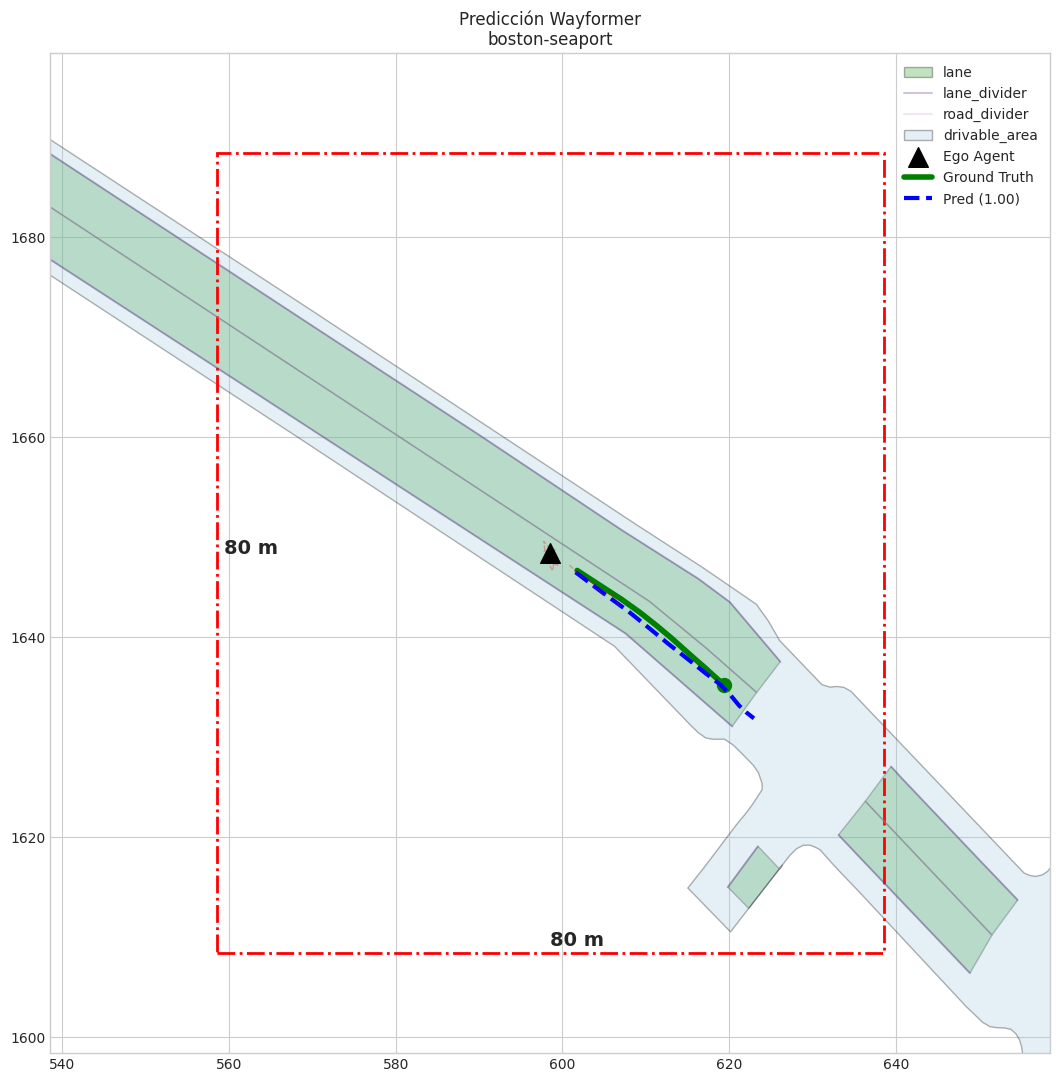

In [22]:
# Elige un índice del dataset de validación
idx_to_plot = 15 # Puedes probar con varios índices
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# Llama a la función
visualize_sample(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

#### Visualitzar prediccions amb diferents trajectories

In [23]:
from matplotlib.animation import FuncAnimation, PillowWriter
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion
import os

def generate_separate_mode_gifs(nusc, helper, dataset, sample_token, instance_token, model, device, output_dir="/root/nuscenes-devkit/python-sdk/main/results/gifs_output"):
    # Crear directorio de salida si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. Configuración de Mapa y Localización
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # 2. Preparar Datos (Inferencia)
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # 3. Transformar a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for mode_traj in preds_local:
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))
    
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    my_patch = (origin_x - 40, origin_y - 40, origin_x + 40, origin_y + 40)

    print(f"Generando GIFs para {len(all_preds_global)} modos en '{output_dir}/'...")

    # ==============================================================================
    # 4. BUCLE: GENERAR UN GIF POR CADA MODO
    # ==============================================================================
    for mode_idx, mode_traj in enumerate(all_preds_global):
        
        probabilidad = probs[mode_idx]
        es_mejor_modo = (mode_idx == probs.argmax())
        color_modo = 'blue' if es_mejor_modo else 'red'
        
        # --- A. Renderizar Mapa Base ---
        # Llamamos a la función SIN pasar 'ax'. Ella creará su propia figura internamente.
        # Capturamos el resultado en una variable 'dummy' por si acaso, pero no la usaremos.
        _ = nusc_map.render_map_patch(
            box_coords=my_patch, 
            layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
            alpha=0.3,
            figsize=(8, 8)
        )
        
        # --- SOLUCIÓN CLAVE ---
        # Obtenemos la Figura y el Eje actuales que render_map_patch acaba de crear.
        # Esto evita el error de la tupla y el error del argumento 'ax'.
        fig = plt.gcf()
        ax = plt.gca()
        
        # Ahora trabajamos sobre 'ax' con seguridad
        title_text = f"Predicción MODO {mode_idx}\nProbabilidad: {probabilidad:.2%}"
        if es_mejor_modo: title_text += " [BEST]"
        ax.set_title(title_text)

        # --- B. Inicializar Objetos Gráficos ---
        ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', zorder=5)
        gt_point, = ax.plot([], [], 'go', markersize=10, label='Ground Truth', zorder=6)
        line, = ax.plot([], [], color=color_modo, linewidth=2, linestyle='--', label='Predicción')
        head, = ax.plot([], [], marker='o', color=color_modo, markersize=6)

        ax.legend(loc='upper right')

        # --- C. Función de Actualización ---
        def update(frame):
            artists = []
            
            # Actualizar GT
            if len(future) > frame:
                gt_point.set_data([future[frame, 0]], [future[frame, 1]])
                artists.append(gt_point)
            
            # Actualizar Predicción
            current_x = mode_traj[:frame+1, 0]
            current_y = mode_traj[:frame+1, 1]
            line.set_data(current_x, current_y)
            artists.append(line)
            
            # Actualizar Cabeza
            if len(mode_traj) > frame:
                head.set_data([mode_traj[frame, 0]], [mode_traj[frame, 1]])
                artists.append(head)
                
            return artists

        # --- D. Crear y Guardar Animación ---
        anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
        
        filename = f"{sample_token[:4]}_modo_{mode_idx}.gif"
        filepath = os.path.join(output_dir, filename)
        
        print(f"  > Guardando: {filename} ...")
        
        # Guardar usando PillowWriter
        anim.save(filepath, writer=PillowWriter(fps=5))
        
        # Cerrar la figura para liberar memoria y preparar la siguiente iteración
        plt.close(fig)

    print("¡Proceso completado! GIFs generados.")

# --- EJECUTAR ---
idx_to_plot = 24
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

generate_separate_mode_gifs(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

Generando GIFs para 3 modos en '/root/nuscenes-devkit/python-sdk/main/results/gifs_output/'...
  > Guardando: 61d9_modo_0.gif ...
  > Guardando: 61d9_modo_1.gif ...
  > Guardando: 61d9_modo_2.gif ...
¡Proceso completado! GIFs generados.



🎲 Visualizando índice aleatorio: 58


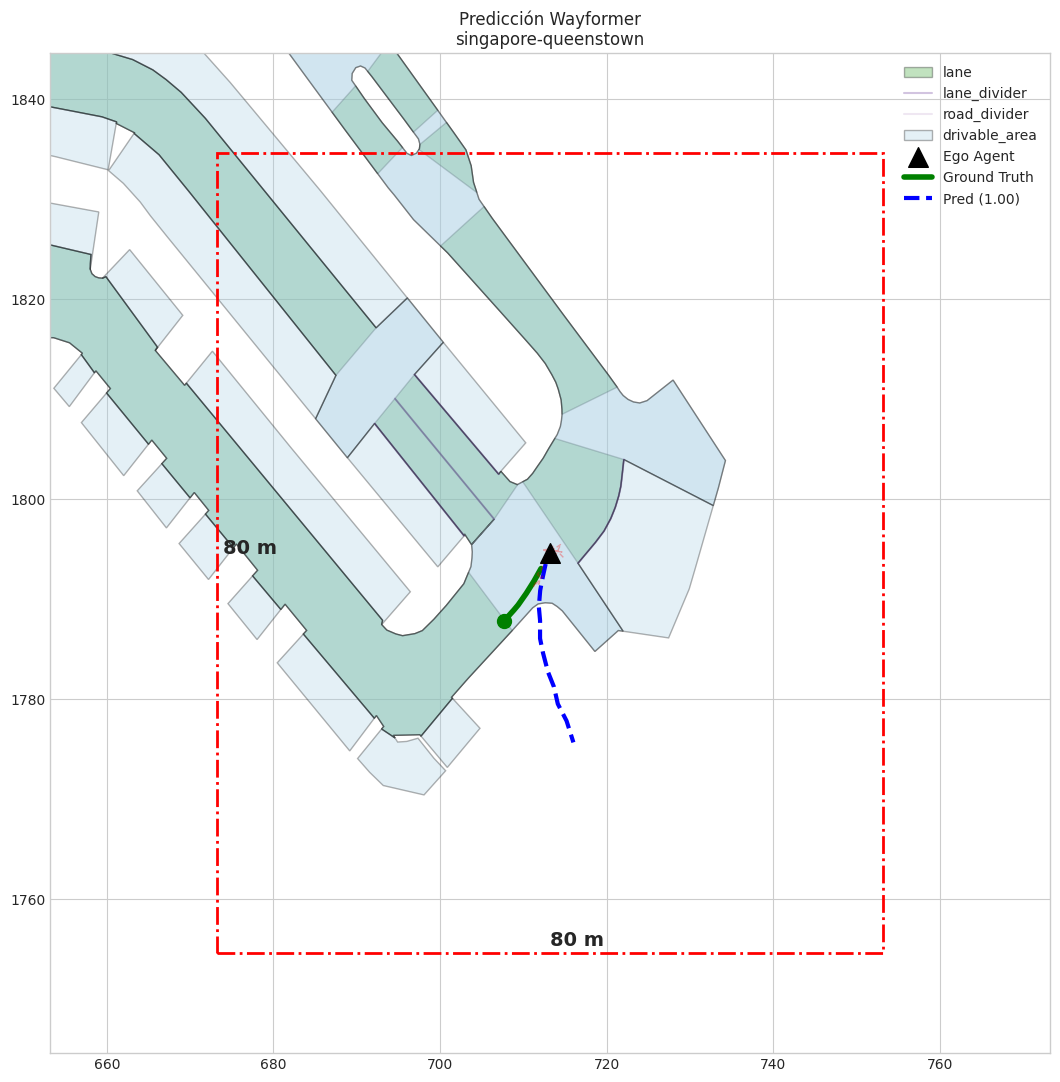


🎲 Visualizando índice aleatorio: 40


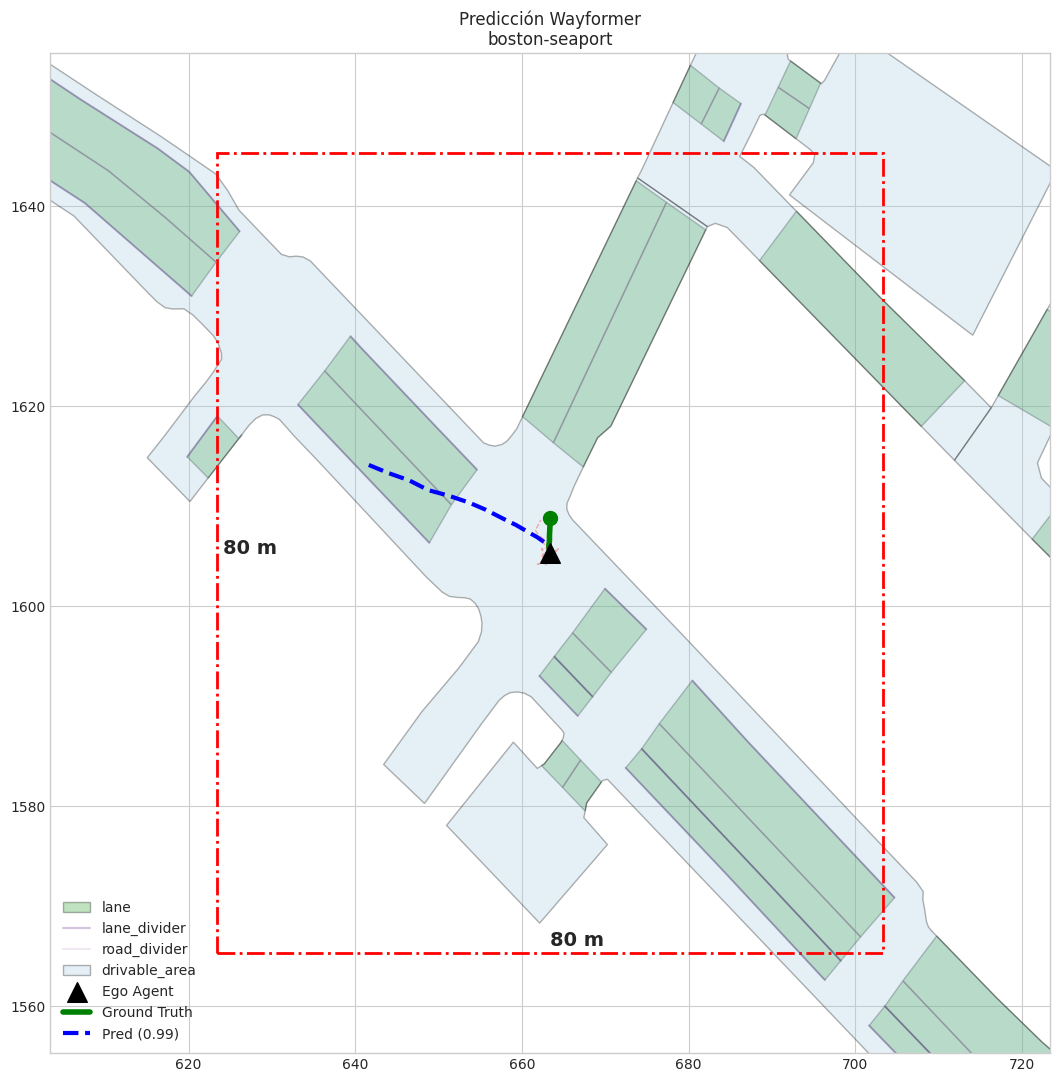


🎲 Visualizando índice aleatorio: 18


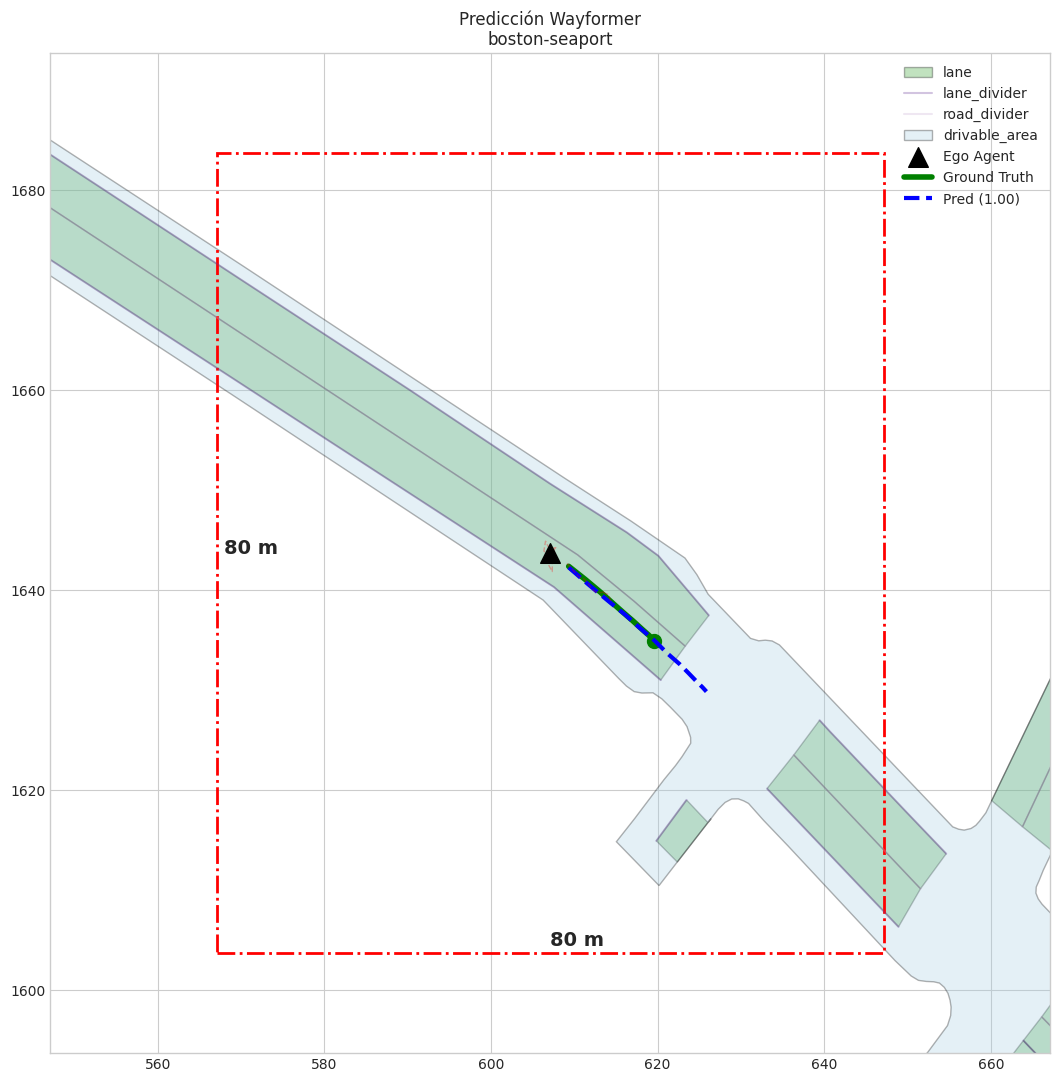

In [24]:
import random

# Elegir 3 índices al azar
indices = random.sample(range(len(val_dataset)), 3)

for idx in indices:
    raw_token = val_dataset.token_list[idx]
    inst_tok, samp_tok = raw_token.split("_")
    
    print(f"\n🎲 Visualizando índice aleatorio: {idx}")
    visualize_sample(helper.data, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera una animación de video con la predicción.
    """
    # 1. Configuración de Mapa y Localización
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # 2. Preparar Datos (Inferencia)
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # 3. Transformar a Global (Predicciones y GT)
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    # Predicciones Globales
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global)) # Shape: (12, 2)
    
    # Ground Truth Global
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    
    # 4. Configurar Figura (Renderizar Mapa estático)
    my_patch = (origin_x - 40, origin_y - 40, origin_x + 40, origin_y + 40)
    
    # Renderizamos el mapa (esto crea la figura automáticamente)
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(8, 8)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Predicción Dinámica\n{location} - {sample_token[:8]}")

    # 5. Inicializar objetos gráficos para la animación
    # Agente Ego (Triángulo fijo en el origen del movimiento)
    ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=5)
    
    # Puntos móviles
    gt_point, = ax.plot([], [], 'go', markersize=10, label='Ground Truth', zorder=6)
    
    # Lista de líneas para los modos predichos
    pred_lines = []
    pred_heads = [] # Puntos en la cabeza de la trayectoria
    
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.2
        width = 2 if i == best_mode else 1
        
        # Línea de historia (traza)
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        # Punto actual (cabeza)
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=5)
        
        pred_lines.append(line)
        pred_heads.append(head)

    ax.legend(loc='upper right')

    # 6. Función de Animación
    def update(frame):
        # Frame va de 0 a 11 (12 pasos)
        
        # Actualizar GT
        if len(future) > frame:
            gt_point.set_data([future[frame, 0]], [future[frame, 1]])
        
        # Actualizar Predicciones
        for i, traj in enumerate(all_preds_global):
            # Traza completa hasta el frame actual
            current_x = traj[:frame+1, 0]
            current_y = traj[:frame+1, 1]
            
            pred_lines[i].set_data(current_x, current_y)
            
            # Cabeza en el frame actual
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
                
        return [gt_point] + pred_lines + pred_heads

    # Crear animación
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close() # Evitar que se muestre la figura estática duplicada
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# Usamos el mismo sample que antes
idx_to_plot = 13
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# Generar y mostrar video
video_html = visualize_sample_video(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)
    
video_html

In [41]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from pyquaternion import Quaternion

def visualize_sample_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera una animación de video con la predicción.
    Devuelve el objeto 'anim' para poder guardarlo o visualizarlo.
    """
    # 1. Configuración de Mapa y Localización
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # 2. Preparar Datos (Inferencia)
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    
    # --- CORRECCIÓN 1: AÑADIR MÁSCARA ---
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    agent_mask = data['agent_mask'].unsqueeze(0).to(device) # <--- IMPORTANTE
    
    model.eval()
    with torch.no_grad():
        # Pasamos la máscara al modelo
        preds, logits = model(bev, agents, agent_mask=agent_mask)
    
    preds_local = preds[0].cpu().numpy()
    
    # Manejo seguro de logits si no existen
    if logits is not None:
        probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    else:
        probs = np.ones(len(preds_local)) / len(preds_local)
    
    # 3. Transformar a Global (Predicciones)
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))
    
    # Ground Truth Global
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    
    # 4. Configurar Figura
    my_patch = (origin_x - 40, origin_y - 40, origin_x + 40, origin_y + 40)
    
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(8, 8)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Predicción Dinámica\n{location}")

    # 5. Inicializar objetos gráficos
    ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=5)
    gt_point, = ax.plot([], [], 'go', markersize=10, label='Ground Truth', zorder=6)
    
    pred_lines = []
    pred_heads = []
    best_mode = probs.argmax()
    
    # Ordenar índices por probabilidad para pintar el mejor al final (encima)
    sorted_indices = np.argsort(probs)
    
    # Creamos las líneas en orden
    lines_dict = {} # Diccionario temporal para guardar referencias
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.2
        width = 2 if i == best_mode else 1
        
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=5)
        
        pred_lines.append(line)
        pred_heads.append(head)

    ax.legend(loc='upper right')

    # 6. Función de Animación
    def update(frame):
        # Actualizar GT
        if len(future) > frame:
            gt_point.set_data([future[frame, 0]], [future[frame, 1]])
        
        # Actualizar Predicciones
        for i, traj in enumerate(all_preds_global):
            pred_lines[i].set_data(traj[:frame+1, 0], traj[:frame+1, 1])
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
                
        return [gt_point] + pred_lines + pred_heads

    # --- CORRECCIÓN 2: DEVOLVER OBJETO ANIM ---
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close() 
    
    return anim

In [43]:
# --- CONFIGURACIÓN ---
idx_to_plot = 13


# Ruta donde guardar
output_dir = "/root/nuscenes-devkit/python-sdk/main/results/videos/"
os.makedirs(output_dir, exist_ok=True) # Crear carpeta si no existe

name_video = f"prediction_video_model_1_idx_{idx_to_plot}.gif" 
ruta_completa = os.path.join(output_dir, name_video)

# Obtener tokens
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

print(f"🎬 Generando animación para sample {idx_to_plot}...")

# 1. Llamar a la función (Devuelve objeto anim)
# NOTA: Pasamos 'helper.data' como primer argumento, no el módulo 'nuscenes'
anim = visualize_sample_video(helper.data, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

if anim is not None:
    print(f"💾 Guardando video en: {ruta_completa}")
    
    # 2. Cambia el writer a 'pillow' (o quítalo, es el defecto para gif)
    anim.save(ruta_completa, writer='pillow', fps=5) 
    
    print("✅ Video guardado.")

    # 3. MOSTRAR EN NOTEBOOK (Opcional)
    display(HTML(anim.to_jshtml()))
else:
    print("❌ Error al generar la animación.")

🎬 Generando animación para sample 13...
💾 Guardando video en: /root/nuscenes-devkit/python-sdk/main/results/videos/prediction_video_model_1_idx_13.gif
✅ Video guardado.


In [33]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_scene_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera un video con la predicción del agente objetivo Y el movimiento real de los vecinos.
    """
    # ---------------------------------------------------------
    # 1. Configuración del Mapa
    # ---------------------------------------------------------
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # ---------------------------------------------------------
    # 2. Inferencia del Agente Principal (Target)
    # ---------------------------------------------------------
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # Transformar predicción a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))

    # Ground Truth del Target
    future_target = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)

    # ---------------------------------------------------------
    # 3. Obtener Vecinos (Tráfico circundante)
    # ---------------------------------------------------------
    all_annotations = helper.get_annotations_for_sample(sample_token)
    neighbor_futures = []
    
    for neighbor in all_annotations:
        # Saltamos al agente principal (ya lo tenemos controlado)
        if neighbor['instance_token'] == instance_token:
            continue
            
        # Obtenemos el futuro de este vecino
        # Nota: Algunos pueden tener menos de 6 segundos de futuro si desaparecen
        fut = helper.get_future_for_agent(neighbor['instance_token'], sample_token, seconds=6, in_agent_frame=False)
        
        # Solo lo añadimos si tiene datos futuros
        if len(fut) > 0:
            neighbor_futures.append(fut)

    # ---------------------------------------------------------
    # 4. Configurar Figura
    # ---------------------------------------------------------
    # Centramos el mapa en el agente principal
    my_patch = (origin_x - 50, origin_y - 50, origin_x + 50, origin_y + 50)
    
    # Renderizar mapa estático
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area', 'ped_crossing'],
        alpha=0.4,
        figsize=(10, 10)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Escena Completa: Predicción (Azul) vs Tráfico Real (Naranja)\n{location}")

    # ---------------------------------------------------------
    # 5. Inicializar Objetos Gráficos
    # ---------------------------------------------------------
    
    # A. Target (Nuestro coche)
    start_point = ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=10)
    gt_point, = ax.plot([], [], 'go', markersize=8, label='Target GT', zorder=9)
    
    # B. Predicciones Target (Líneas)
    pred_lines = []
    pred_heads = []
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.1
        width = 3 if i == best_mode else 1
        
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=4)
        pred_lines.append(line)
        pred_heads.append(head)

    # C. Vecinos (Nube de puntos naranja)
    # Usamos un solo objeto scatter para todos los vecinos por eficiencia
    neighbors_scatter = ax.scatter([], [], c='orange', s=60, edgecolors='k', label='Traffic', zorder=8)

    ax.legend(loc='upper right')

    # ---------------------------------------------------------
    # 6. Loop de Animación
    # ---------------------------------------------------------
    def update(frame):
        # frame: 0 a 11
        
        # 1. Actualizar Target GT
        if len(future_target) > frame:
            gt_point.set_data([future_target[frame, 0]], [future_target[frame, 1]])
            
        # 2. Actualizar Predicciones Target
        for i, traj in enumerate(all_preds_global):
            # Dibujar traza hasta el momento actual
            pred_lines[i].set_data(traj[:frame+1, 0], traj[:frame+1, 1])
            # Dibujar cabeza
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
        
        # 3. Actualizar VECINOS
        current_neighbor_pos = []
        for fut in neighbor_futures:
            # Si este vecino todavía existe en este frame (tiempo t)
            if len(fut) > frame:
                current_neighbor_pos.append(fut[frame]) # [x, y]
        
        if len(current_neighbor_pos) > 0:
            neighbors_scatter.set_offsets(np.array(current_neighbor_pos))
        else:
            neighbors_scatter.set_offsets(np.empty((0, 2))) # Limpiar si no hay nadie
            
        return [gt_point, neighbors_scatter] + pred_lines + pred_heads

    # Generar
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# Prueba con el mismo índice u otro interesante
idx_to_plot = 55
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

visualize_scene_video(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

# Analysis of the Transformer-Based Trajectory Prediction Model


## 1. What Works Well

### 1.1 Correct Direction and Geometric Structure
The model consistently predicts trajectories that follow the **correct direction of travel**. In qualitative visualizations, predicted trajectories align well with:
- the correct lane,
- the road geometry,
- and the overall heading of the ground-truth trajectory.

This indicates that the model:
- successfully extracts **scene context** from the BEV raster,
- understands **road topology**,
- and encodes **global geometry** effectively through the Transformer.

Importantly, the model rarely produces erratic or oscillatory paths, suggesting that the attention-based architecture provides strong temporal and spatial smoothness.

---

### 1.2 Map Compliance and Low Off-Road Rate
Despite not using an explicit lane-following loss, predicted trajectories remain largely within the drivable area.

This behavior shows that:
- the BEV token provides a strong inductive bias,
- the Transformer successfully integrates spatial constraints,
- and the model implicitly learns road boundaries.

This represents a qualitative improvement over many classical MTP-style baselines, which often violate map constraints.

---

### 1.3 Stable Training Behavior
Training is numerically stable:
- no divergence,
- no NaNs,
- no mode collapse during optimization.

Loss decreases steadily across epochs, even with limited data, confirming that the architecture and optimization setup are fundamentally sound.

---

## 2. What Goes Wrong

### 2.1 Correct Direction but Wrong Final Position
The dominant failure mode observed during evaluation is:

> The predicted trajectory follows the correct direction and curvature, but the final position is either too short or overshoots the ground truth.

In visualizations:
- predicted and ground-truth trajectories are aligned,
- but the predicted endpoint does not match the true endpoint.

---

### 2.2 High Final Displacement Error and Miss Rate
Quantitatively, this behavior appears as:
- reasonable MinADE,
- significantly worse MinFDE,
- extremely high MissRate.

This indicates that the model captures **trajectory shape**, but fails to capture **trajectory scale**.

---

## 3. Root Cause Diagnosis

### 3.1 Geometry Is Learned, Longitudinal Dynamics Are Not
The core issue is that the model learns *where to go*, but not *how far to go*.

Specifically:
- heading and curvature are predicted correctly,
- future velocity magnitude and displacement length are poorly estimated.

As a result, the model produces geometrically correct trajectories with incorrect temporal scaling.

---

### 3.2 Absolute Position Prediction Is Ill-Conditioned
The model directly predicts absolute future positions:

\[
(x_t, y_t)
\]

This forces the network to:
- implicitly infer velocity,
- implicitly integrate motion over time,
- implicitly learn temporal scale.

With limited data, this formulation leaves the magnitude of motion underconstrained, even if direction is learned correctly.

---

### 3.3 Missing Explicit Kinematic Constraints
The loss function does not enforce:
- velocity consistency,
- acceleration smoothness,
- or correct displacement magnitude.

Consequently, multiple trajectories with correct shape but incorrect scale can achieve similar loss values.

---

### 3.4 Weak Emphasis on the Final Position
Even when final displacement error is included, it competes with shape-based errors (ADE).

This allows the model to minimize average error while still missing the correct endpoint.

---

## 4. How the Diagnosis Was Confirmed

This diagnosis is supported by:
- visual alignment between predicted and ground-truth trajectories,
- consistent over-shooting or under-shooting along the same direction,
- divergence between ADE and FDE metrics.

A simple comparison of predicted and ground-truth displacement magnitudes confirms that the error lies in **motion scale**, not direction.

---

## 5. Summary

### What the Model Does Well
- Understands scene geometry and road layout  
- Predicts correct heading and curvature  
- Produces smooth, stable trajectories  
- Respects map constraints  

### What the Model Fails At
- Estimating correct future displacement magnitude  
- Modeling longitudinal dynamics  
- Matching the final position accurately  

### Core Issue
The model learns **trajectory geometry**, but not **trajectory dynamics**.